In [1]:
import numpy as np
import pandas as pd

In [2]:
import os

In [3]:
base_data_dir = './data/alzheimer'
train_base_dir = f'{base_data_dir}/train'
test_base_dir = f'{base_data_dir}/test'

In [4]:
class_distributions = {}
classes = os.listdir(train_base_dir)

In [5]:
for class_name in classes:
    class_distributions[class_name] = len(os.listdir(f'{train_base_dir}/{class_name}'))

In [6]:
class_distributions

{'MildDemented': 717,
 'ModerateDemented': 52,
 'NonDemented': 2560,
 'VeryMildDemented': 1792}

In [7]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation

#### Distribution of classes in the train dataset

([0, 1, 2, 3],
 [Text(0, 0, 'MildDemented'),
  Text(1, 0, 'ModerateDemented'),
  Text(2, 0, 'NonDemented'),
  Text(3, 0, 'VeryMildDemented')])

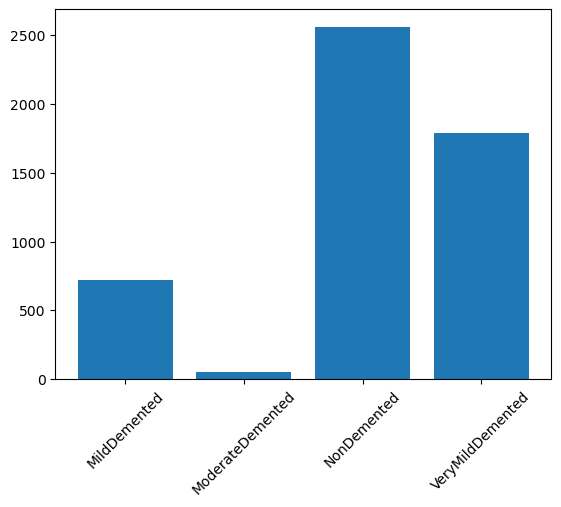

In [8]:
plt.bar(classes, class_distributions.values())
plt.xticks(rotation=45)

In [9]:
from PIL import Image

In [10]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)
    return image.width, image.height

In [11]:
from tqdm.notebook import tqdm

In [12]:
class_dimensions_distributions = {
    'width': [],
    'height': [],
    'class': []
}

In [13]:
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        image_width, image_height = get_image_dimensions(image_path)
        class_dimensions_distributions['width'].append(image_width)
        class_dimensions_distributions['height'].append(image_height)
        class_dimensions_distributions['class'].append(class_name)

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/2560 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

In [14]:
dimensions_df = pd.DataFrame(class_dimensions_distributions)

In [15]:
dimensions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121 entries, 0 to 5120
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   width   5121 non-null   int64 
 1   height  5121 non-null   int64 
 2   class   5121 non-null   object
dtypes: int64(2), object(1)
memory usage: 120.2+ KB


In [16]:
dimensions_df.describe()

width  height
count  5121.0  5121.0
mean    176.0   208.0
std       0.0     0.0
min     176.0   208.0
25%     176.0   208.0
50%     176.0   208.0
75%     176.0   208.0
max     176.0   208.0

#### Distribution of photos' dimensions

In [17]:
dimensions_df['width'].value_counts(), dimensions_df['height'].value_counts()

(width
 176    5121
 Name: count, dtype: int64,
 height
 208    5121
 Name: count, dtype: int64)

In [18]:
del dimensions_df

In [19]:
def image_to_numpy(image_path):
    image = Image.open(image_path)
    return np.array(image).astype(np.uint8)

In [20]:
# setting tensor to store all images' pixels
images = np.empty((5121, 208, 176), dtype=np.uint8)
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i
images_labels = np.empty(5121, dtype=np.uint8)

In [21]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        images[image_idx] = image_to_numpy(image_path)
        images_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/2560 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

In [22]:
import seaborn as sns

#### Displaying heatmap for each class - whiter is weaker density

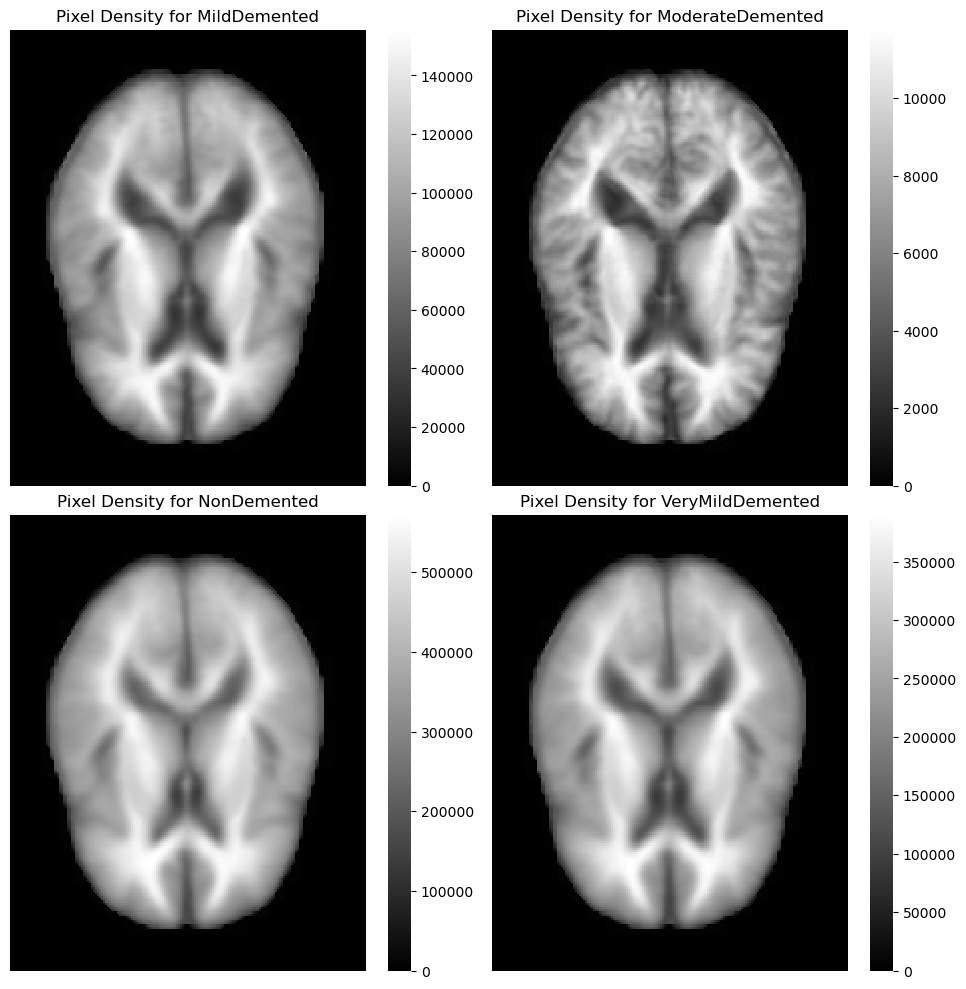

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Pixel Density for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

### Drop all empty pixels to reduce dimensions

#### Using SVD

In [24]:
# U, S, V_t = np.linalg.svd(images.reshape(images.shape[0], -1), full_matrices=False)
# k = int(0.2 * images.shape[0])

In [25]:
# S = np.diag(S)
# svd_images = U[:, :k] @ (S[:k, :k] @ V_t[:k,:])

In [26]:
# svd_images = svd_images.reshape(*(images.shape))

In [27]:
# fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
# fig.tight_layout()

# for i in range(len(classes)):
#     ax = axes[i//2, i%2]
#     class_images = images[np.where(images_labels == i)] - svd_images[np.where(images_labels == i)]
#     heatmap = np.sum(class_images, axis=0)
#     sns.heatmap(heatmap, ax=ax, cmap='gray')
#     ax.set_title(f'Pixel Density for {classes[i]}')
#     ax.get_yaxis().set_visible(False)
#     ax.get_xaxis().set_visible(False)

In [28]:
# get leftmost non empty pixel
non_empty_pixels = np.where(images > 0)[1:]

In [29]:
non_empty_pixels

(array([ 16,  16,  16, ..., 191, 191, 191], dtype=int64),
 array([ 56,  64,  65, ..., 112, 115, 116], dtype=int64))

In [30]:
uppermost_pixel = np.min(non_empty_pixels[0])
bottommost_pixel = np.max(non_empty_pixels[0])
leftmost_pixel = np.min(non_empty_pixels[1])
rightmost_pixel = np.max(non_empty_pixels[1])

In [31]:
# top left
leftmost_pixel, uppermost_pixel

(16, 16)

In [32]:
# bottom right
rightmost_pixel, bottommost_pixel

(159, 191)

In [33]:
# dropping
images = images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

In [34]:
images.shape

(5121, 176, 144)

In [35]:
# number of reduced dimensions
208 * 176 - 25344

11264

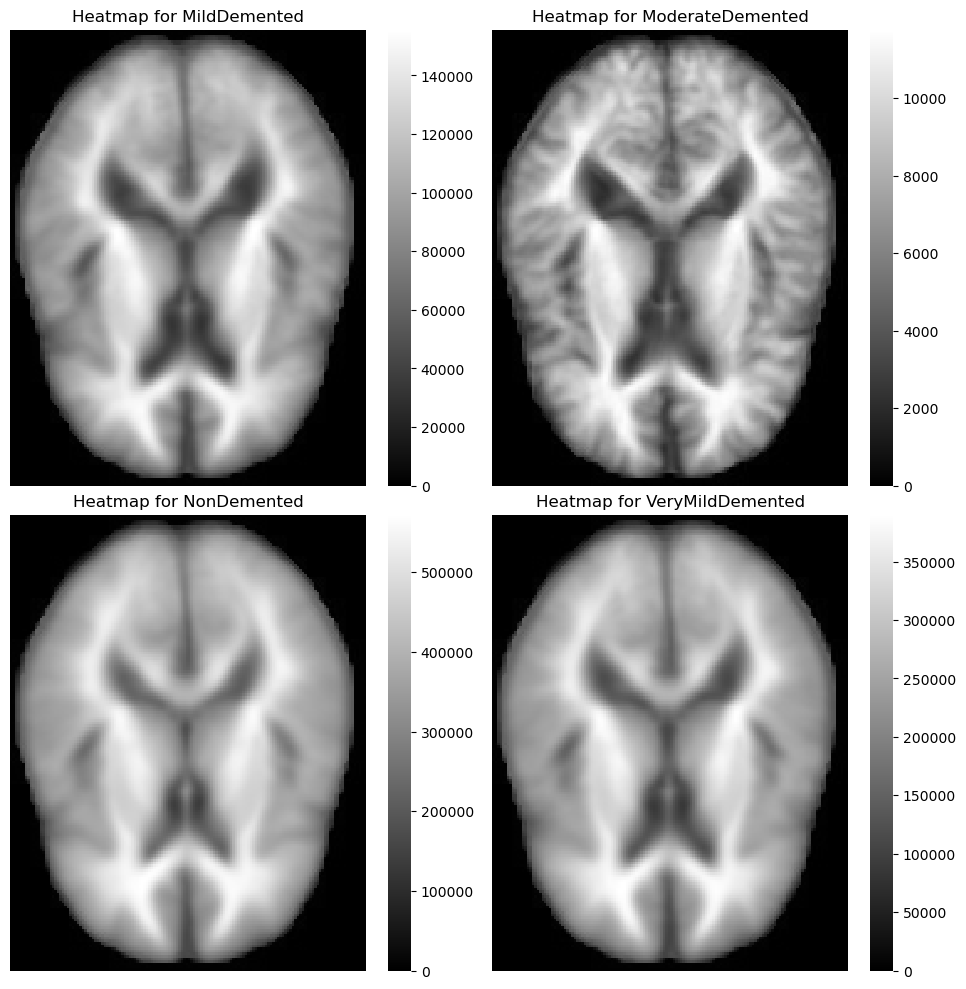

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

(0.0, 250.0)

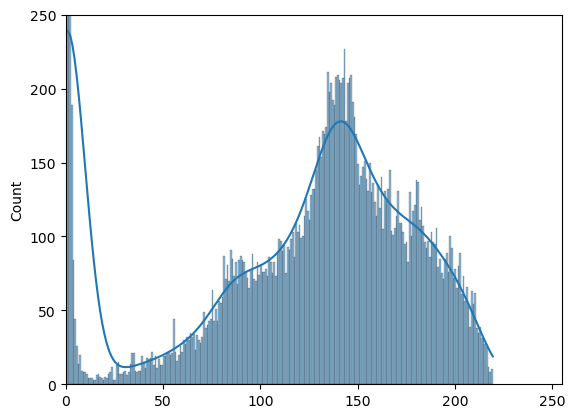

In [37]:
histogram = images.mean(axis=0).flatten()

ax = sns.histplot(histogram, bins=255, kde=True)
plt.xlim([0, 255])
plt.ylim([0, 250])

#### Showing distribution of pixels in each class

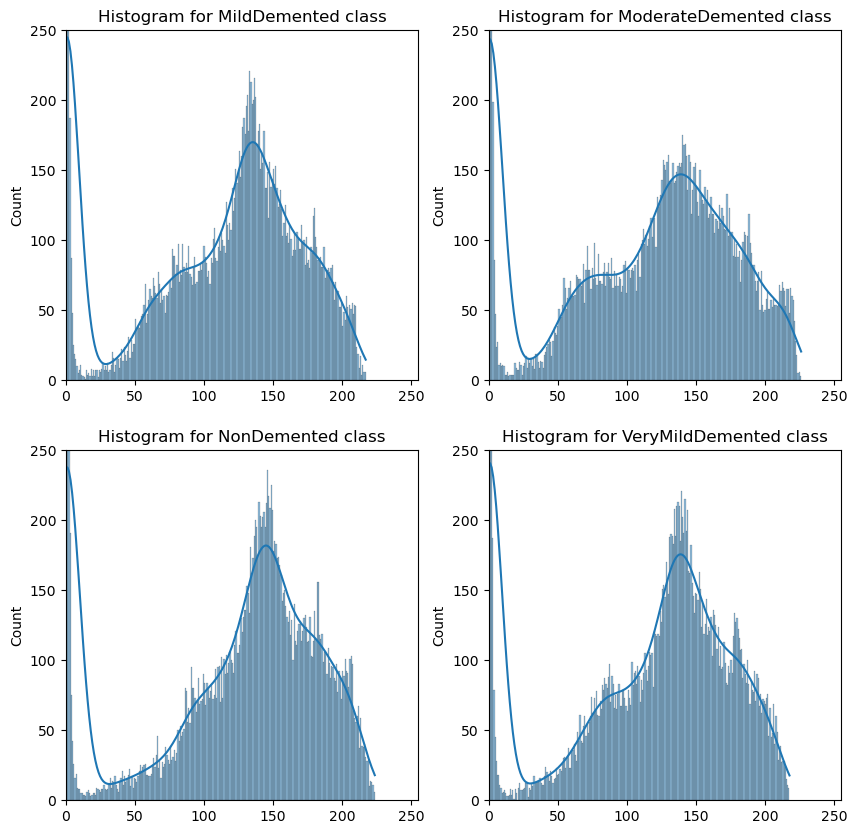

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Histogram for {classes[i]} class')
    sns.histplot(images[images_labels == i].mean(axis=0).flatten(), bins=255, kde=True, ax=ax)
    ax.set_xlim([0, 255])
    ax.set_ylim([0, 250])
    # ax.hist(images[:, random_pixels[i]//176, random_pixels[i]%144])

#### Show distribution of random pixels per class

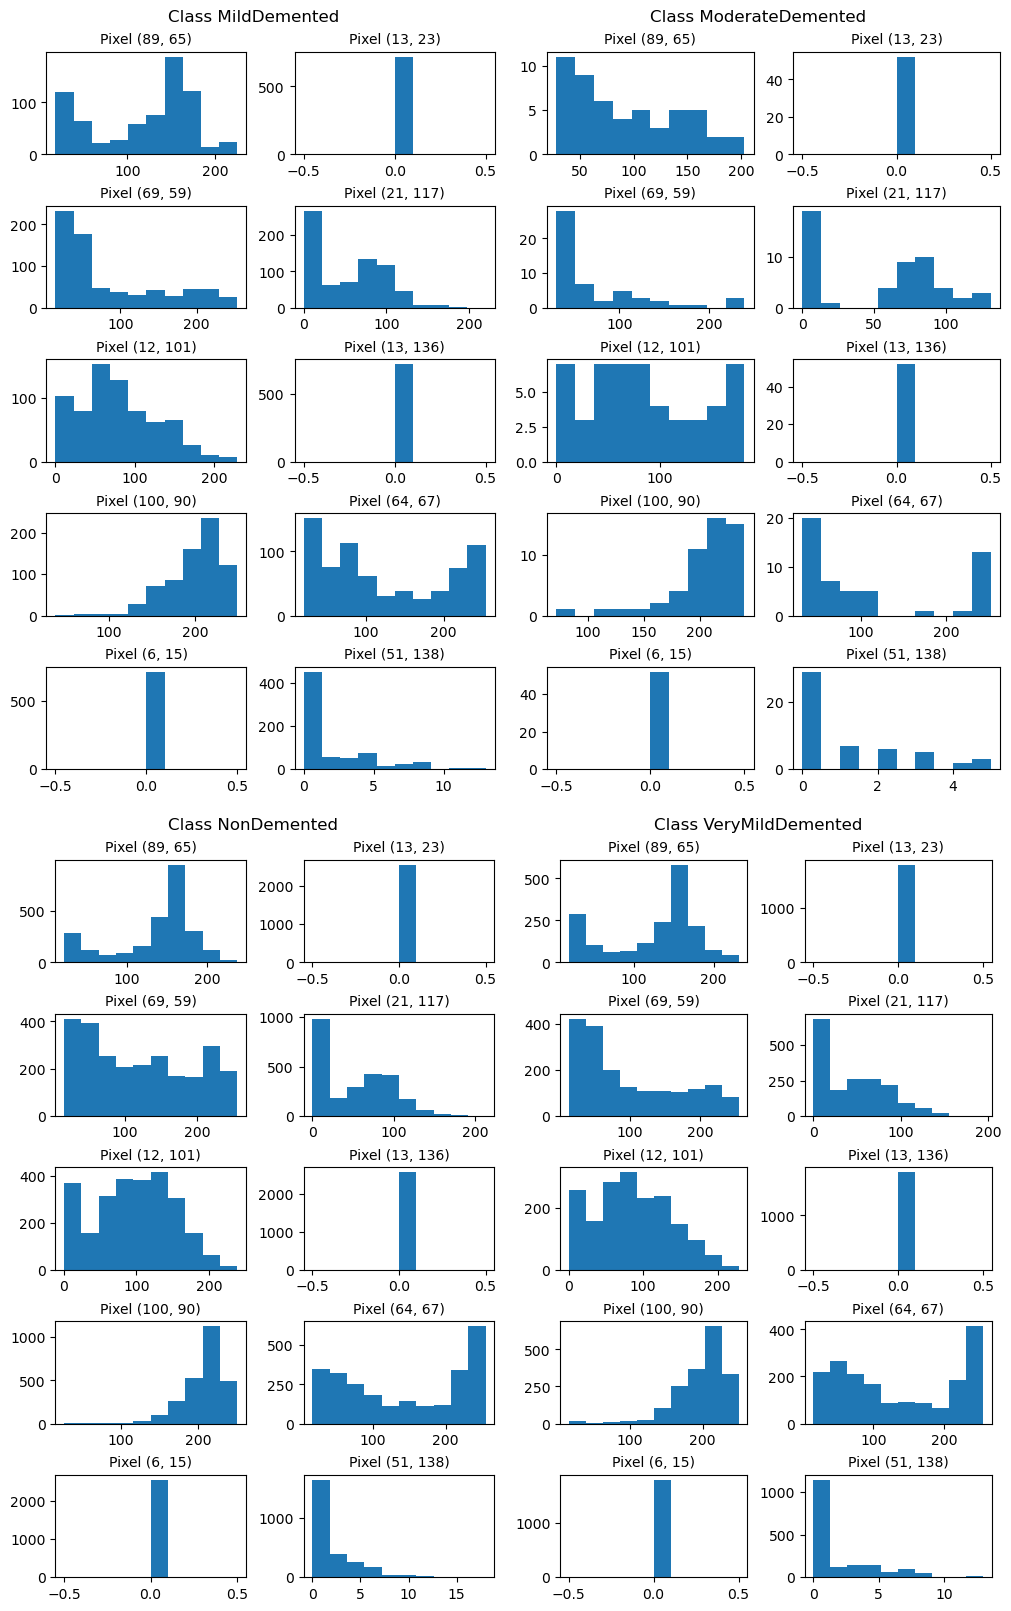

In [39]:
fig = plt.figure(constrained_layout=True, figsize=(10, 16))
subfigs = fig.subfigures(2, 2)

random_pixels = np.random.default_rng().choice(176 * 144, size=10, replace=False)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {classes[class_idx]}')
    axes = subfig.subplots(5, 2)
    class_images = images[np.where(images_labels == class_idx)]
    for i in range(10):
        ax = axes[i//2, i%2]
        ax.hist(class_images[:, random_pixels[i]//176, random_pixels[i]%144])
        ax.set_title(f'Pixel {(random_pixels[i]//176, random_pixels[i]%144)}', fontsize=10)

#### NOT normalizing the images as the decoding process is less successful when dealing with a small range of numbers

In [40]:
# images = images / 255.0

### Show Fourier transformation of each class

In [41]:
def fourier_transformed(image, shifted=False):
    # centering the frequency values for better visibility
    fft_image = np.fft.fft2(image)
    # fft_conj_image = np.conj(fft_image)
    # # will always be non-negative real values
    # transformed = np.real(fft_image * fft_conj_image)
    if shifted:
        return np.fft.fftshift(fft_image)
    return fft_image

def inverse_fourier_transformed(transformed_image, shifted=False):
    if shifted:
        transformed_image = np.fft.ifftshift(transformed_image)
    # getting the rescaled spatial image, shifted
    inverse_fft_image = np.fft.ifft2(transformed_image)
    # inverse_fft_conj_image = np.conj(inverse_fft_image)
    # inverse_transformed = np.real(inverse_fft_image * inverse_fft_conj_image)
    inverse_transformed = np.real(inverse_fft_image)
    # inverse_transformed = np.abs(inverse_fft_image)
    # normalizing the values as norm of each pixel can be very high
    inverse_transformed = 255 * inverse_transformed / inverse_transformed.max()
    return inverse_transformed


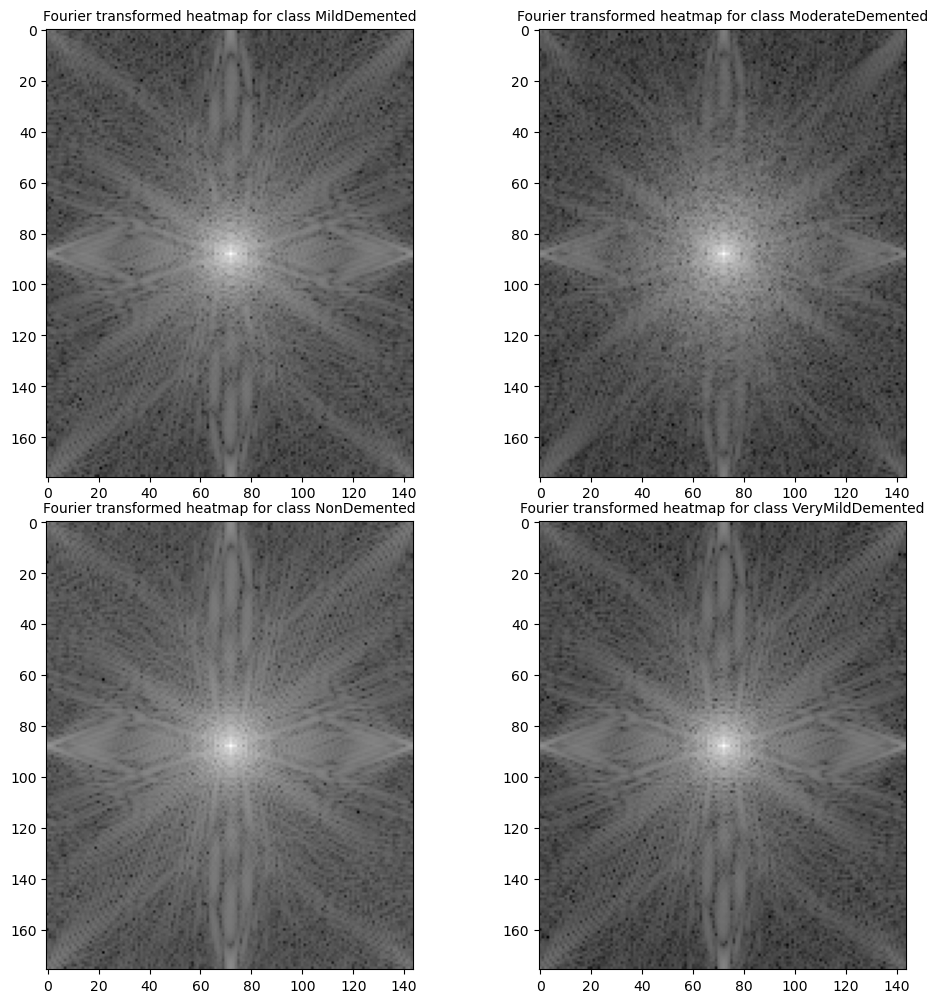

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    ax.set_title(f'Fourier transformed heatmap for class {classes[i]}', fontsize=10)
    class_images_mean = images[images_labels == i].mean(axis=0)
    class_mean_fourier_transformed = fourier_transformed(class_images_mean, False)
    ax.imshow(np.log10(np.abs(np.fft.fftshift(class_mean_fourier_transformed))), cmap='gray')
    # ax.imshow(class_images_mean, cmap='gray')

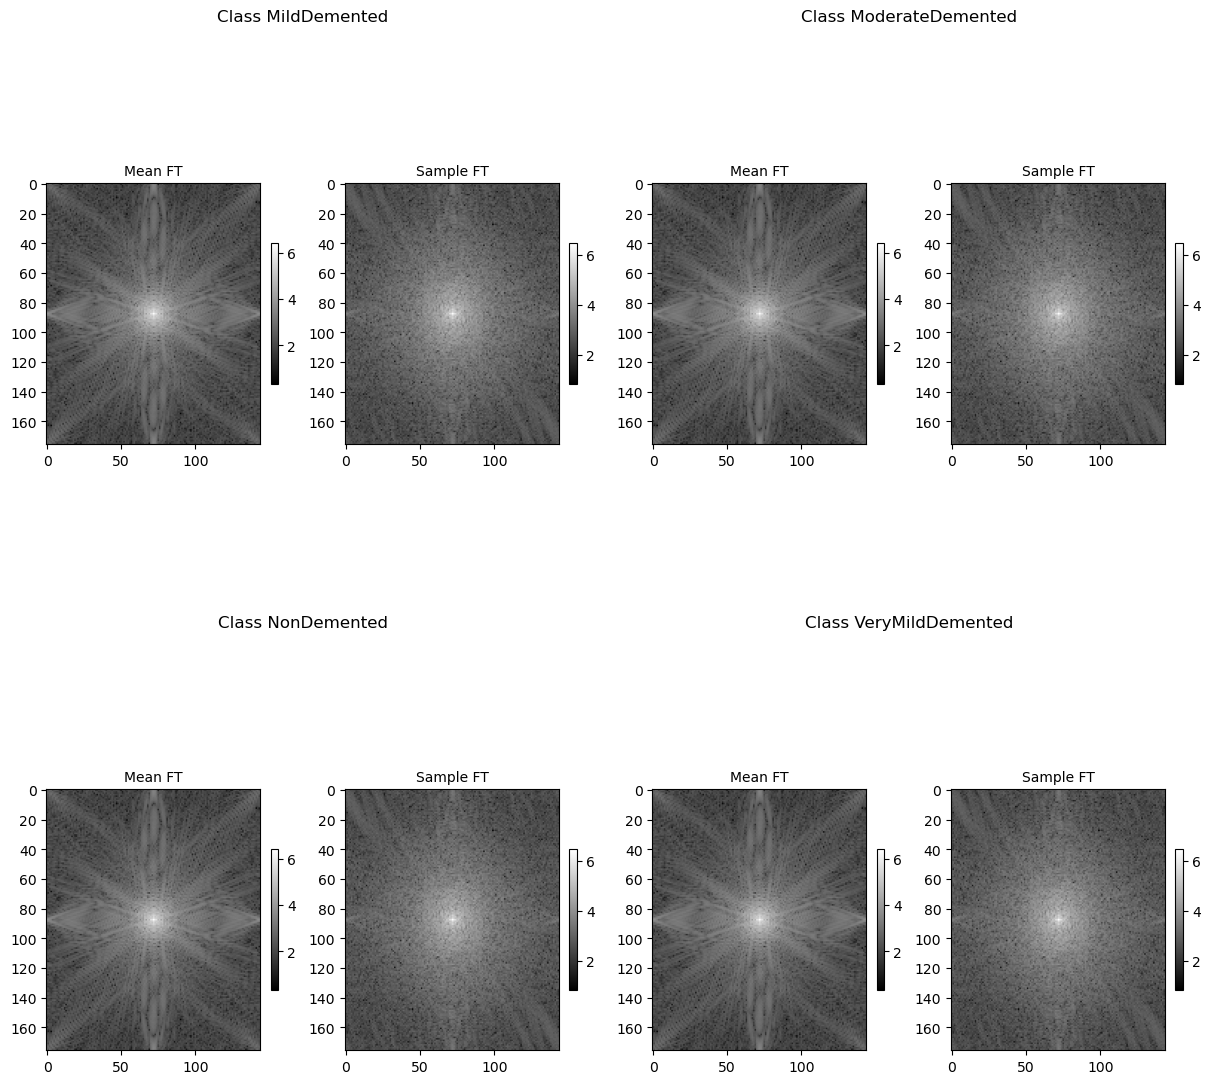

In [43]:
epsilon = 0.000001

fig = plt.figure(constrained_layout=True, figsize=(12, 12))
subfigs = fig.subfigures(2, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {classes[class_idx]}')
    axes = subfig.subplots(1, 2)
    class_images = images[np.where(images_labels == class_idx)]
    class_images_mean = images[images_labels == i].mean(axis=0)
    class_mean_fourier_transformed = fourier_transformed(class_images_mean, False)
    scaled_transformed = np.log10(np.abs(np.fft.fftshift(class_mean_fourier_transformed)))
    pos0 = axes[0].imshow(scaled_transformed, cmap='gray', vmin=scaled_transformed.min(), vmax=scaled_transformed.max())
    axes[0].set_title('Mean FT', fontsize=10)
    fig.colorbar(pos0, ax=axes[0], shrink=0.25)

    class_image = images[images_labels == i][0]
    image_fourier_transformed_shifted = fourier_transformed(class_image, shifted=True)
    scaled_shifted_transformed = np.log10(np.abs(image_fourier_transformed_shifted) + epsilon)
    pos1 = axes[1].imshow(scaled_shifted_transformed, cmap='gray', vmin=scaled_shifted_transformed.min(), vmax=scaled_shifted_transformed.max())
    axes[1].set_title('Sample FT', fontsize=10)
    fig.colorbar(pos1, ax=axes[1], shrink=0.25)


In [44]:
ones = np.ones_like(images[0])
epsilon = 0.000001
border = 0
center_y, center_x = ones.shape[0]//2, ones.shape[1]//2
center = np.array([center_y, center_x])

ones[center_y-border:center_y+border+1, center_x-border:center_x+border+1] = 0 + epsilon
v, u = np.mgrid[:images[0].shape[0], :images[0].shape[1]]

distances_from_center = np.sqrt(
    np.square(v - center[0]) + np.square(u - center[1])
)
threshold = 40
mask = distances_from_center <= threshold

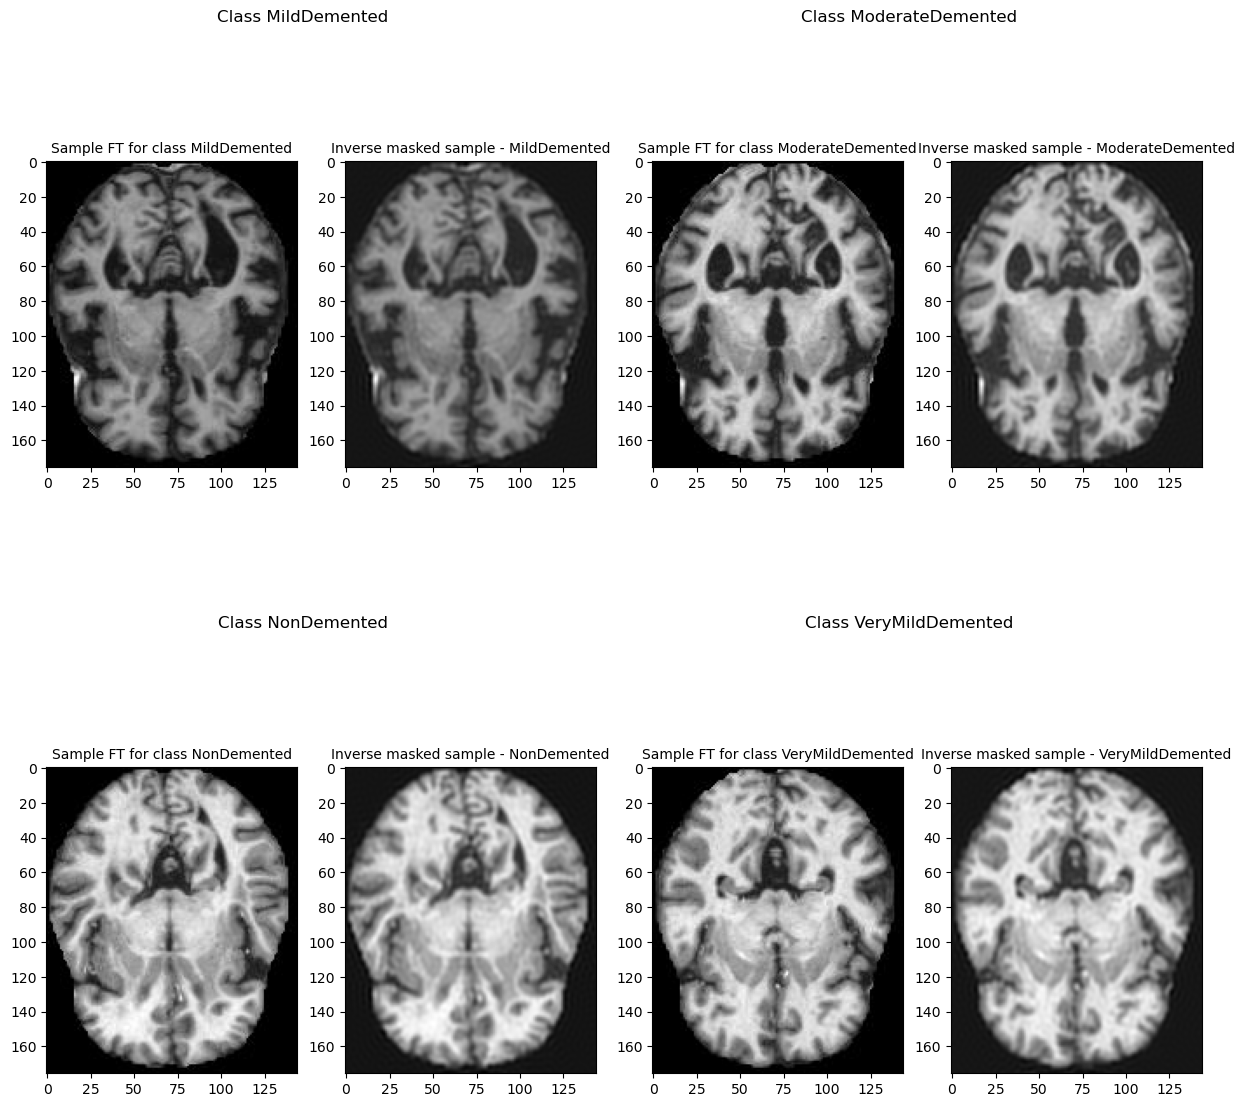

In [45]:
fig = plt.figure(constrained_layout=True, figsize=(12, 12))
subfigs = fig.subfigures(2, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {classes[class_idx]}')
    axes = subfig.subplots(1, 2)
    class_images = images[np.where(images_labels == class_idx)]

    class_image = class_images[0]
    image_fourier_transformed_shifted_masked = fourier_transformed(class_image, shifted=True) * mask
    # axes[0].imshow(np.log10(np.abs(image_fourier_transformed_shifted_masked) + epsilon), cmap='gray')
    axes[0].imshow(class_image, cmap='gray')
    axes[0].set_title(f'Sample FT for class {classes[class_idx]}', fontsize=10)

    inverse_masked_image = np.fft.ifft2(np.fft.ifftshift(image_fourier_transformed_shifted_masked)).real
    axes[1].imshow(inverse_masked_image, cmap='gray')
    axes[1].set_title(f'Inverse masked sample - {classes[class_idx]}', fontsize=10)

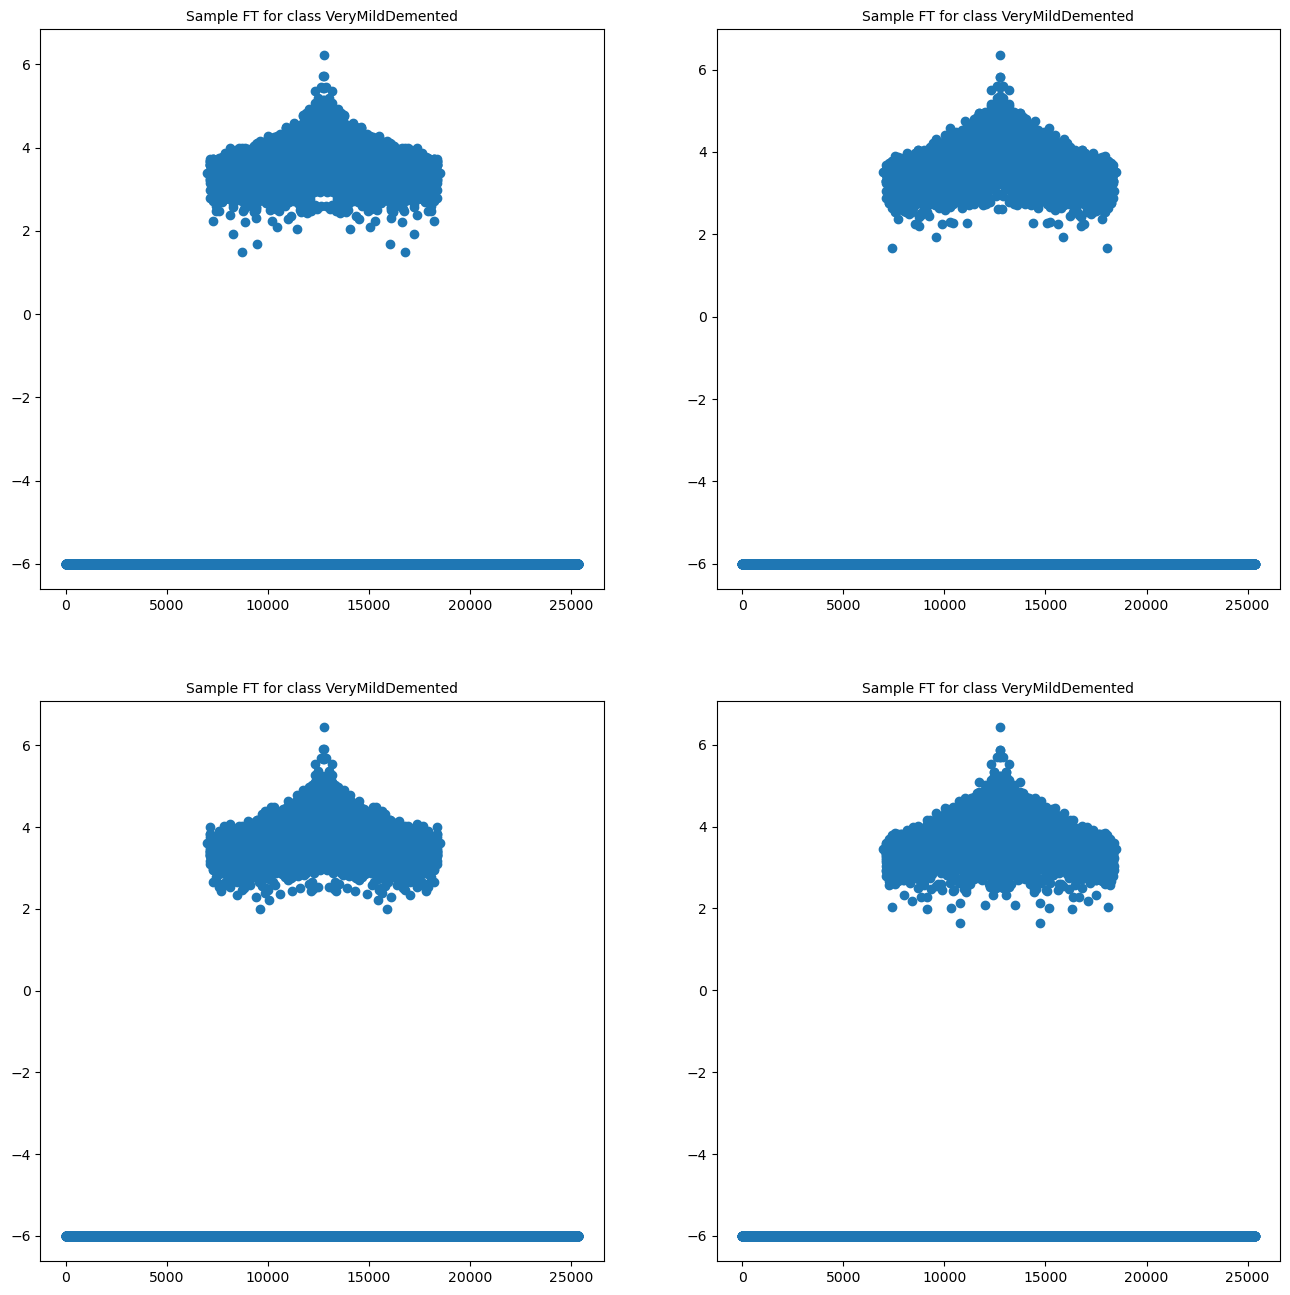

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for i in range(4):
    class_images = images[np.where(images_labels == i)]

    class_image = class_images[0]
    image_fourier_transformed_shifted_flattened = fourier_transformed(class_image, shifted=True).flatten() * mask.flatten()
    axes[i//2, i%2].scatter(np.arange(image_fourier_transformed_shifted_flattened.shape[0]), np.log10(np.abs(image_fourier_transformed_shifted_flattened) + epsilon))
    axes[i//2, i%2].set_title(f'Sample FT for class {classes[class_idx]}', fontsize=10)

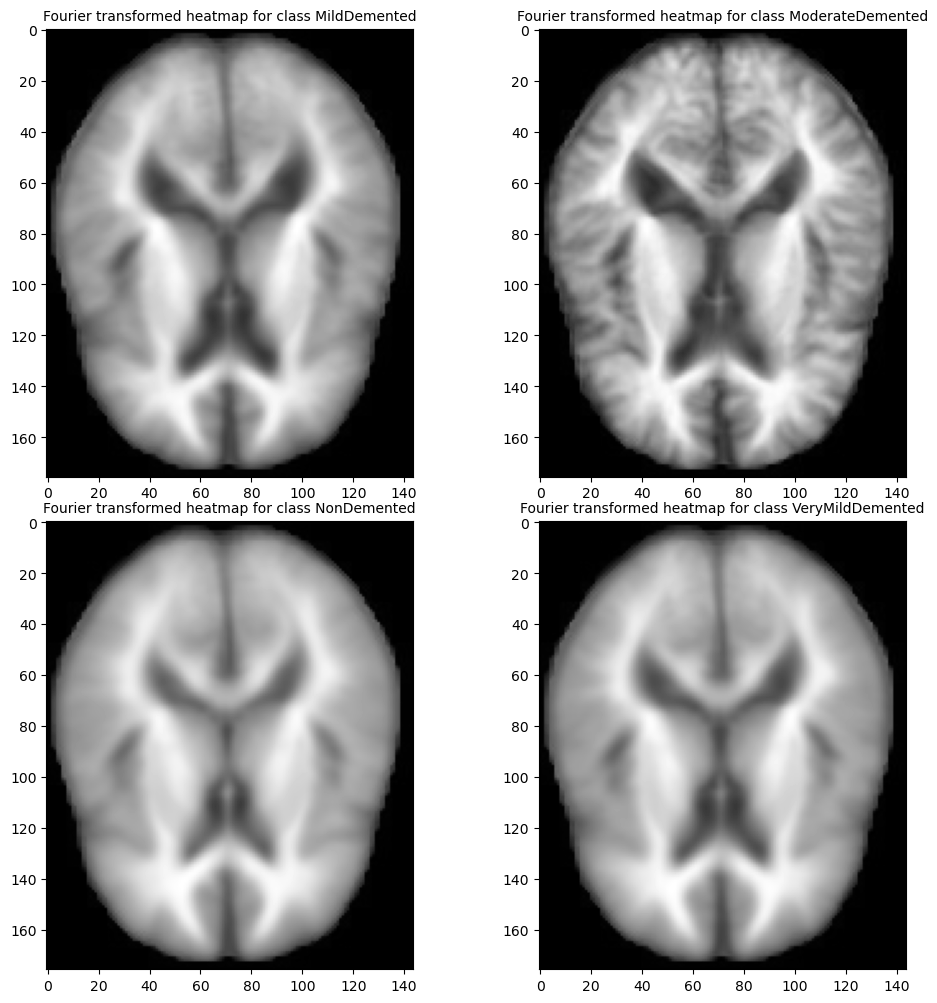

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    ax.set_title(f'Fourier transformed heatmap for class {classes[i]}', fontsize=10)
    class_images_mean = images[images_labels == i].mean(axis=0)
    class_mean_fourier_transformed = fourier_transformed(class_images_mean)
    class_mean_inverse_fourier_transformed = inverse_fourier_transformed(class_mean_fourier_transformed)
    ax.imshow(class_mean_inverse_fourier_transformed, cmap='gray')

### Filters

In [48]:
import scipy as sp

In [49]:
def plot_side_by_side(first_images, second_images, first_title, second_title):
    # plot
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    subfigs = fig.subfigures(2, 2)

    for class_idx, subfig in enumerate(subfigs.flat):
        subfig.suptitle(classes[class_idx])
        axes = subfig.subplots(1, 2)

        blurred_images = first_images[np.where(images_labels == class_idx)]
        blurred_heatmap = np.sum(blurred_images, axis=0)
        sns.heatmap(blurred_heatmap, ax=axes[0], cmap='gray')
        axes[0].set_title(first_title)
        axes[0].get_yaxis().set_visible(False)
        axes[0].get_xaxis().set_visible(False)

        original_images = second_images[np.where(images_labels == class_idx)]
        original_heatmap = np.sum(original_images, axis=0)
        sns.heatmap(original_heatmap, ax=axes[1], cmap='gray')
        axes[1].set_title(second_title)
        axes[1].get_yaxis().set_visible(False)
        axes[1].get_xaxis().set_visible(False)

#### Applying max filter with a 3x3 kernel

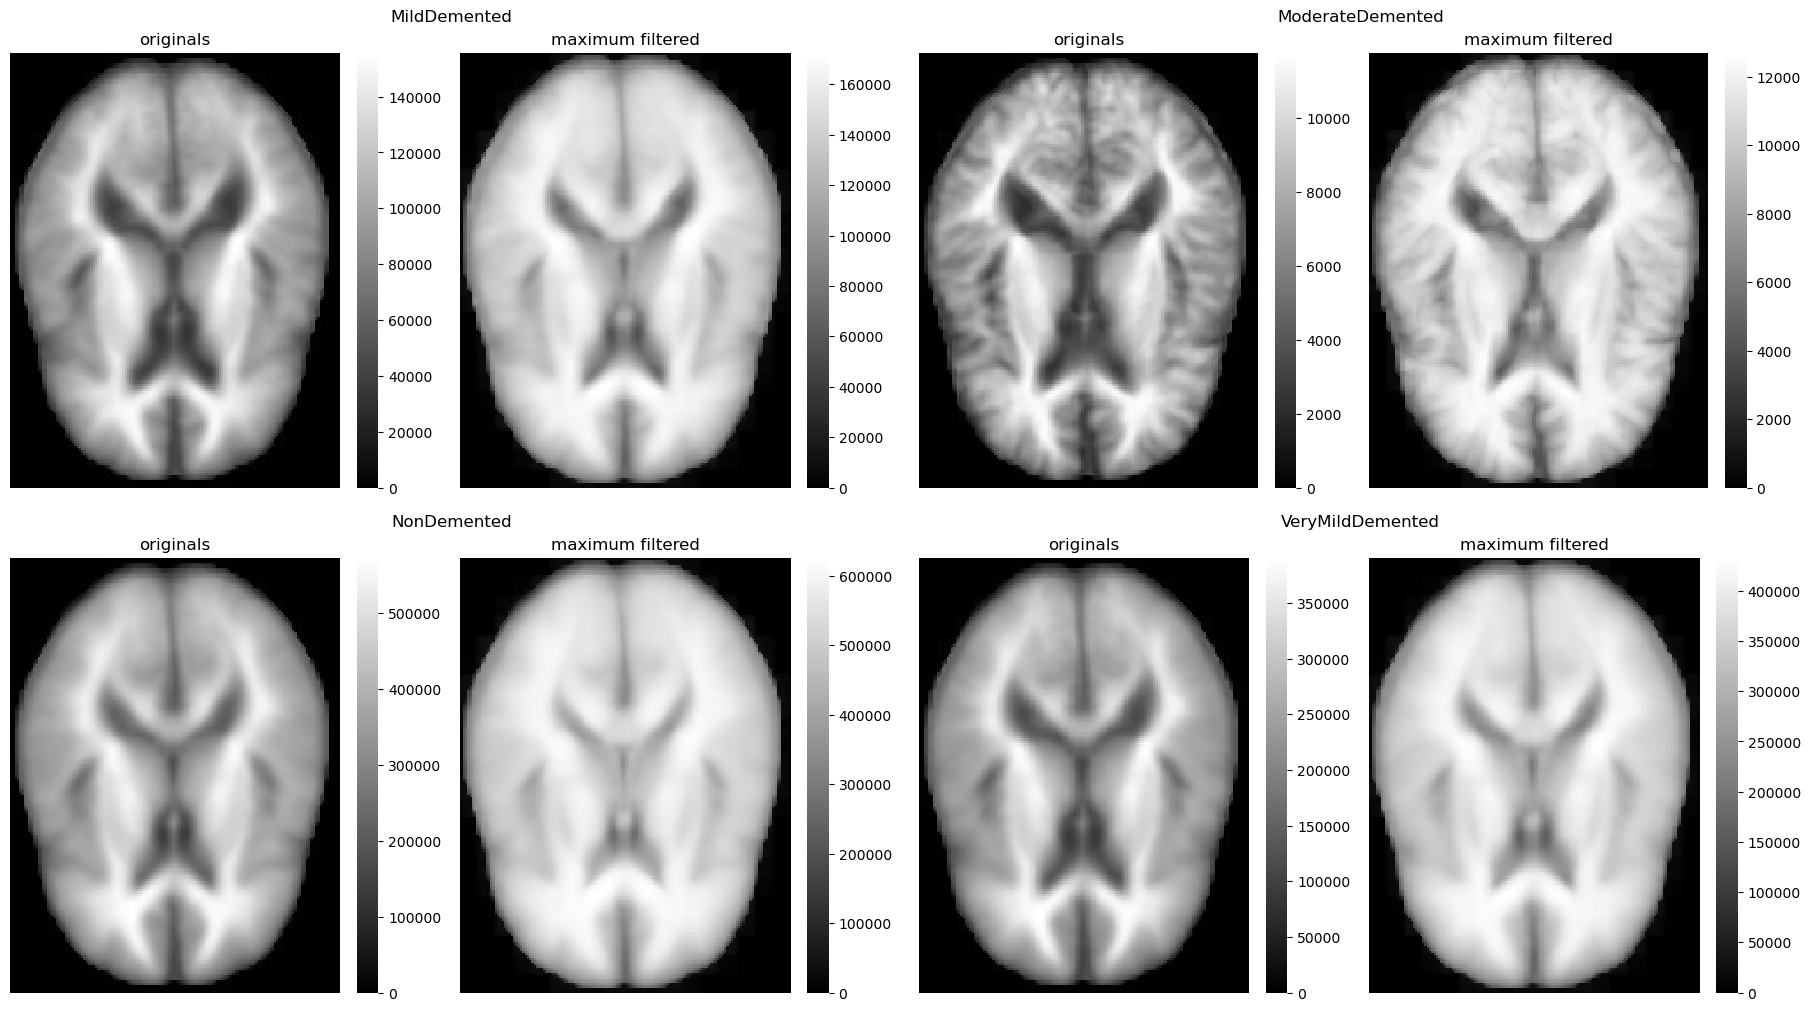

In [50]:
plot_side_by_side(images, sp.ndimage.maximum_filter(images, size=3), 'originals', 'maximum filtered')

#### Minimum filter

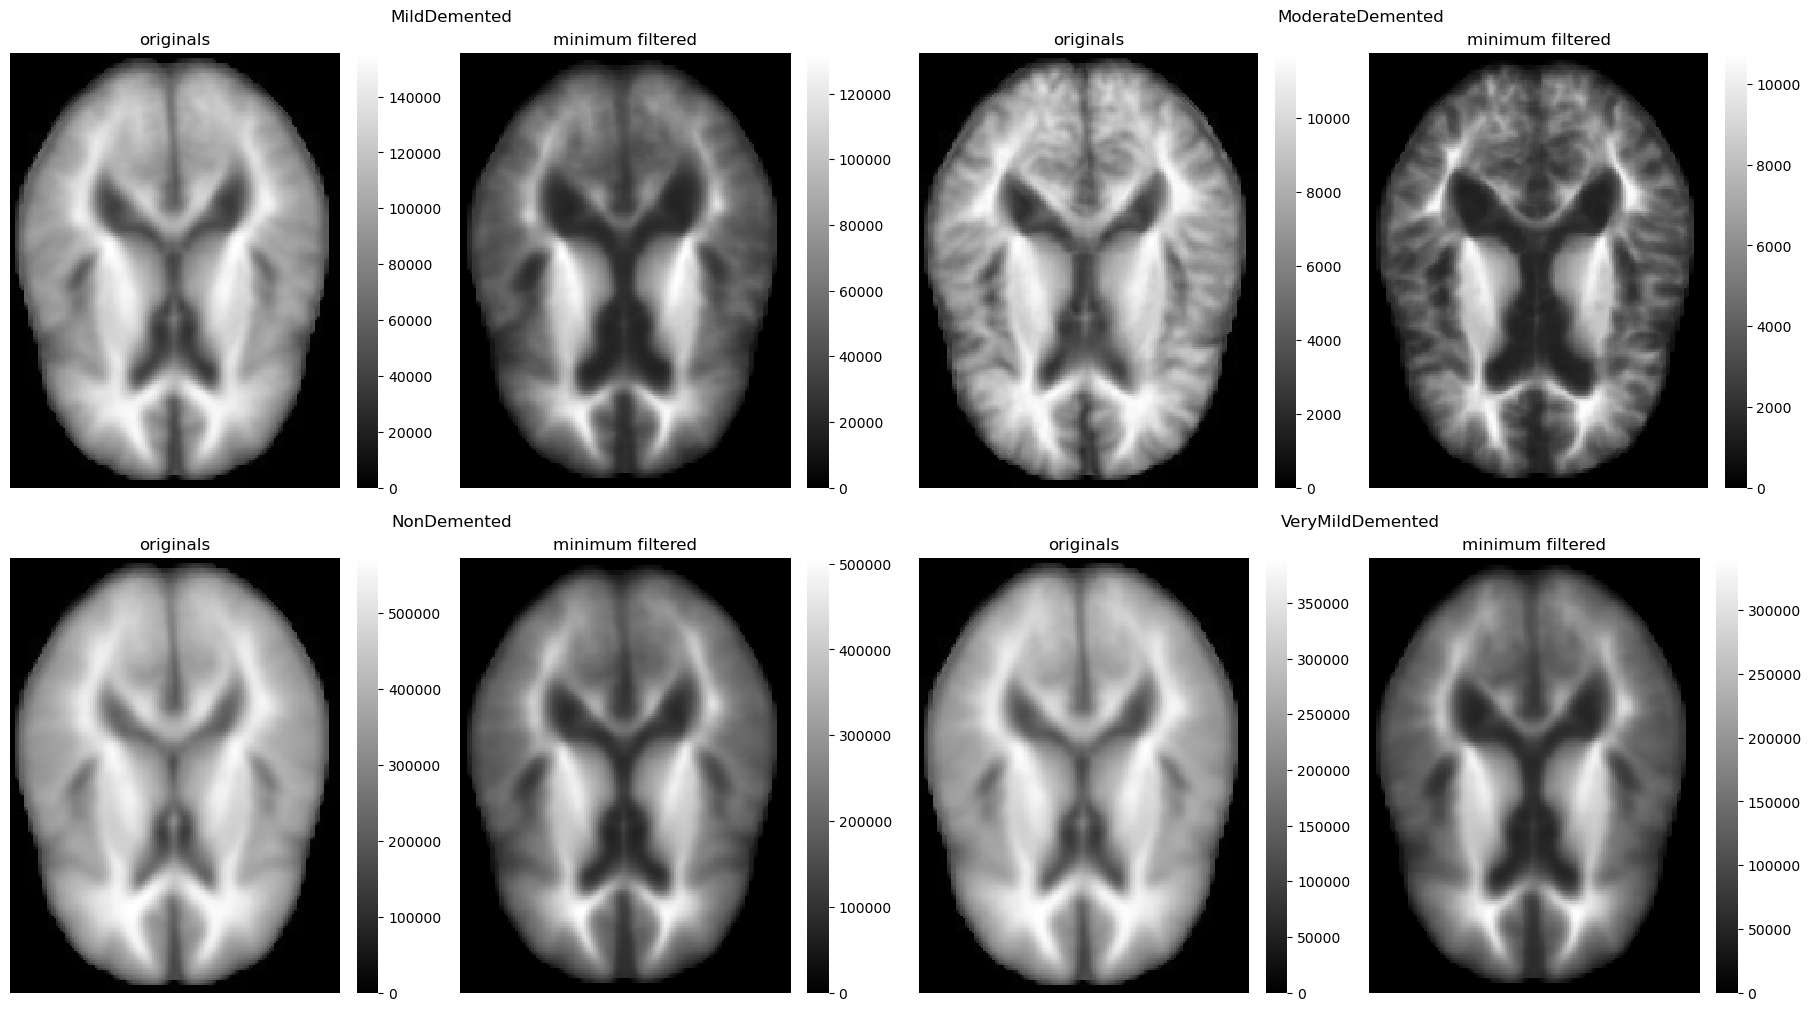

In [51]:
plot_side_by_side(images, sp.ndimage.minimum_filter(images, size=3), 'originals', 'minimum filtered')

#### Sobel filter

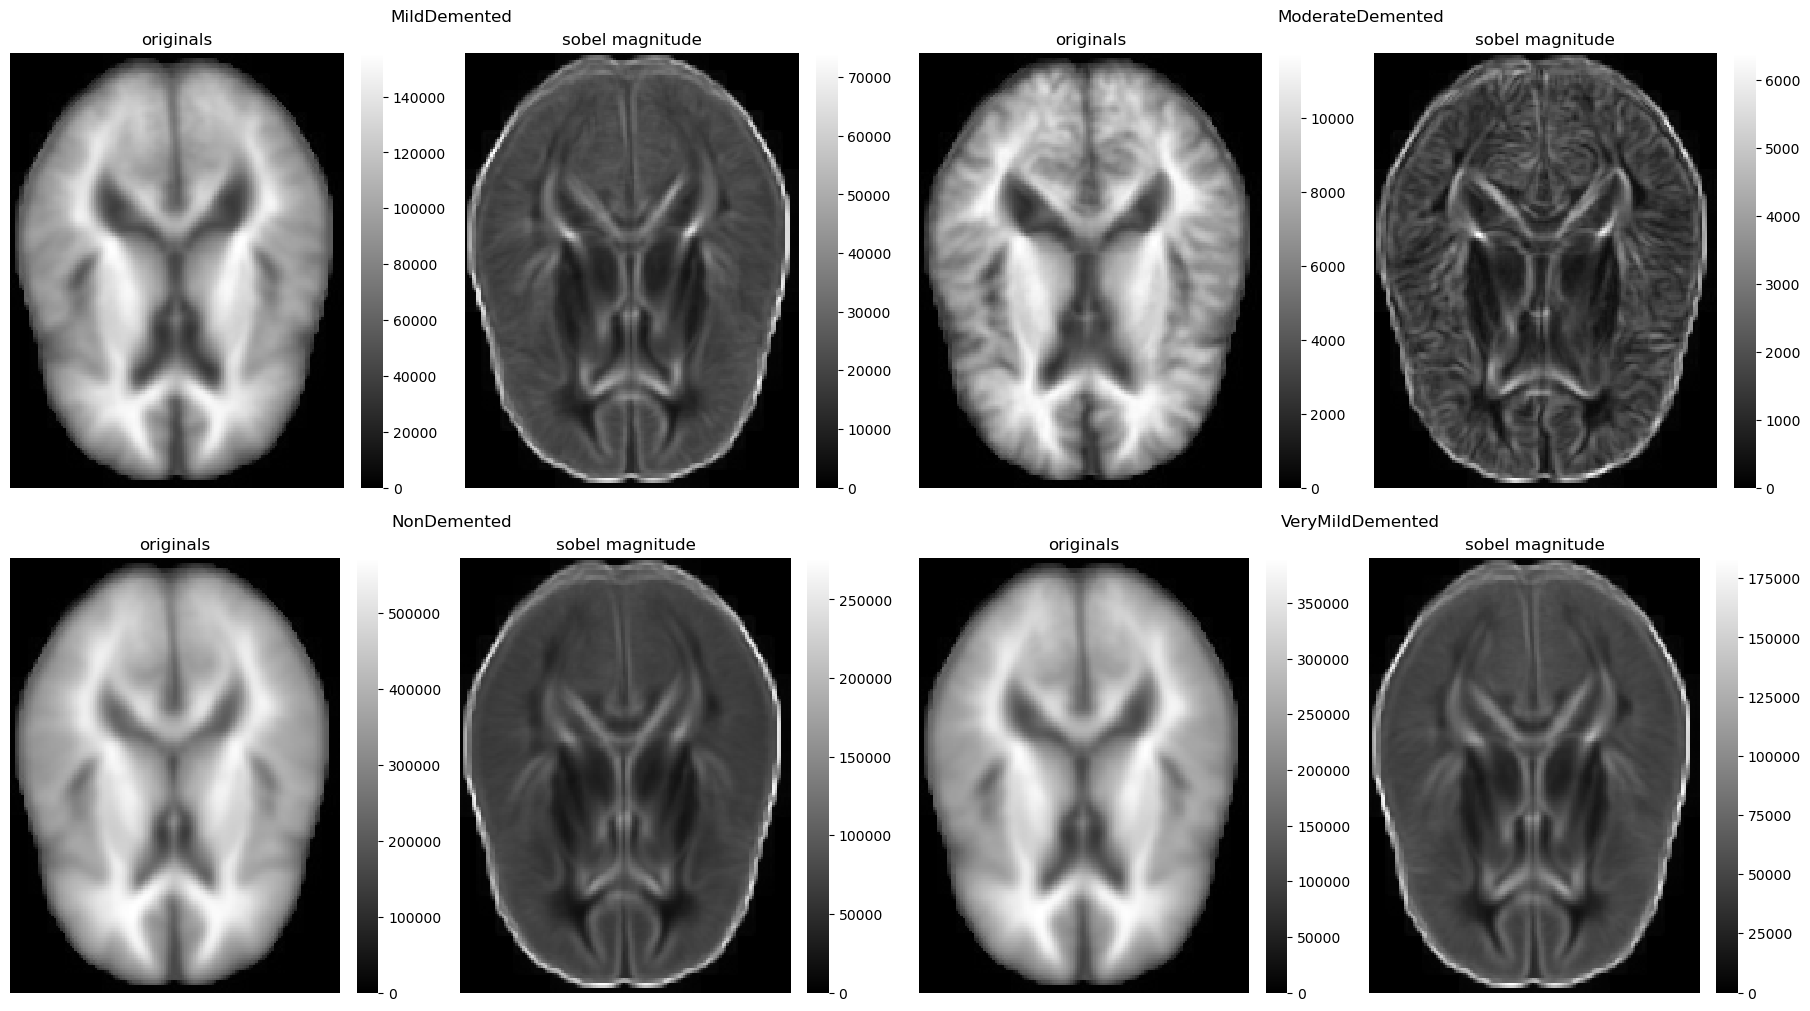

In [52]:
sobel_x_gradients = sp.ndimage.sobel(images / 255, axis=1)
sobel_y_gradients = sp.ndimage.sobel(images / 255, axis=2)
sobel_magnitude = np.sqrt(sobel_x_gradients ** 2 + sobel_y_gradients ** 2)
sobel_magnitude = 255 * sobel_magnitude / np.max(sobel_magnitude)
sobel_gradient_angle = np.arctan2(sobel_y_gradients, sobel_x_gradients)

plot_side_by_side(images, sobel_magnitude, 'originals', 'sobel magnitude')

#### Prewitt filter

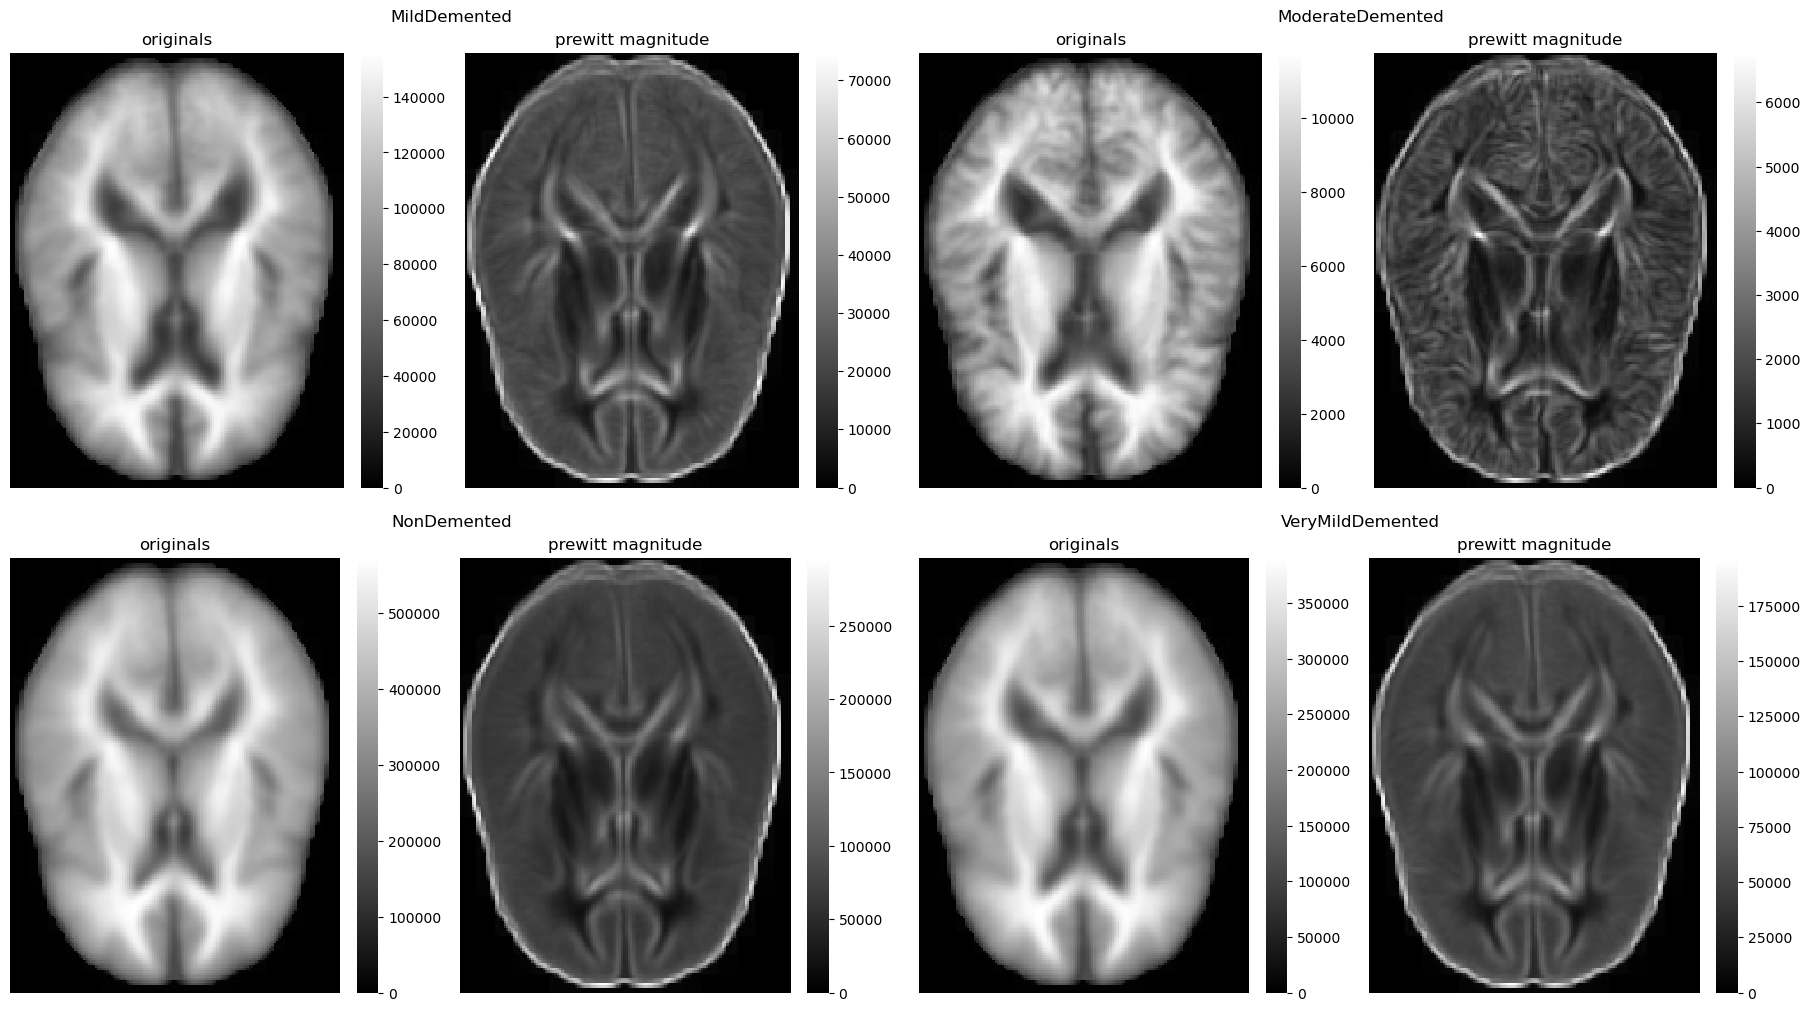

In [53]:
prewitt_x_gradients = sp.ndimage.prewitt(images / 255, axis=1)
prewitt_y_gradients = sp.ndimage.prewitt(images / 255, axis=2)
prewitt_magnitude = np.sqrt(prewitt_y_gradients ** 2 + prewitt_x_gradients ** 2)
prewitt_magnitude = 255 * prewitt_magnitude / prewitt_magnitude.max()
prewitt_gradient_angle = np.arctan2(prewitt_y_gradients, prewitt_x_gradients)

plot_side_by_side(images, prewitt_magnitude, 'originals', 'prewitt magnitude')

#### Compare prewitt with sobel

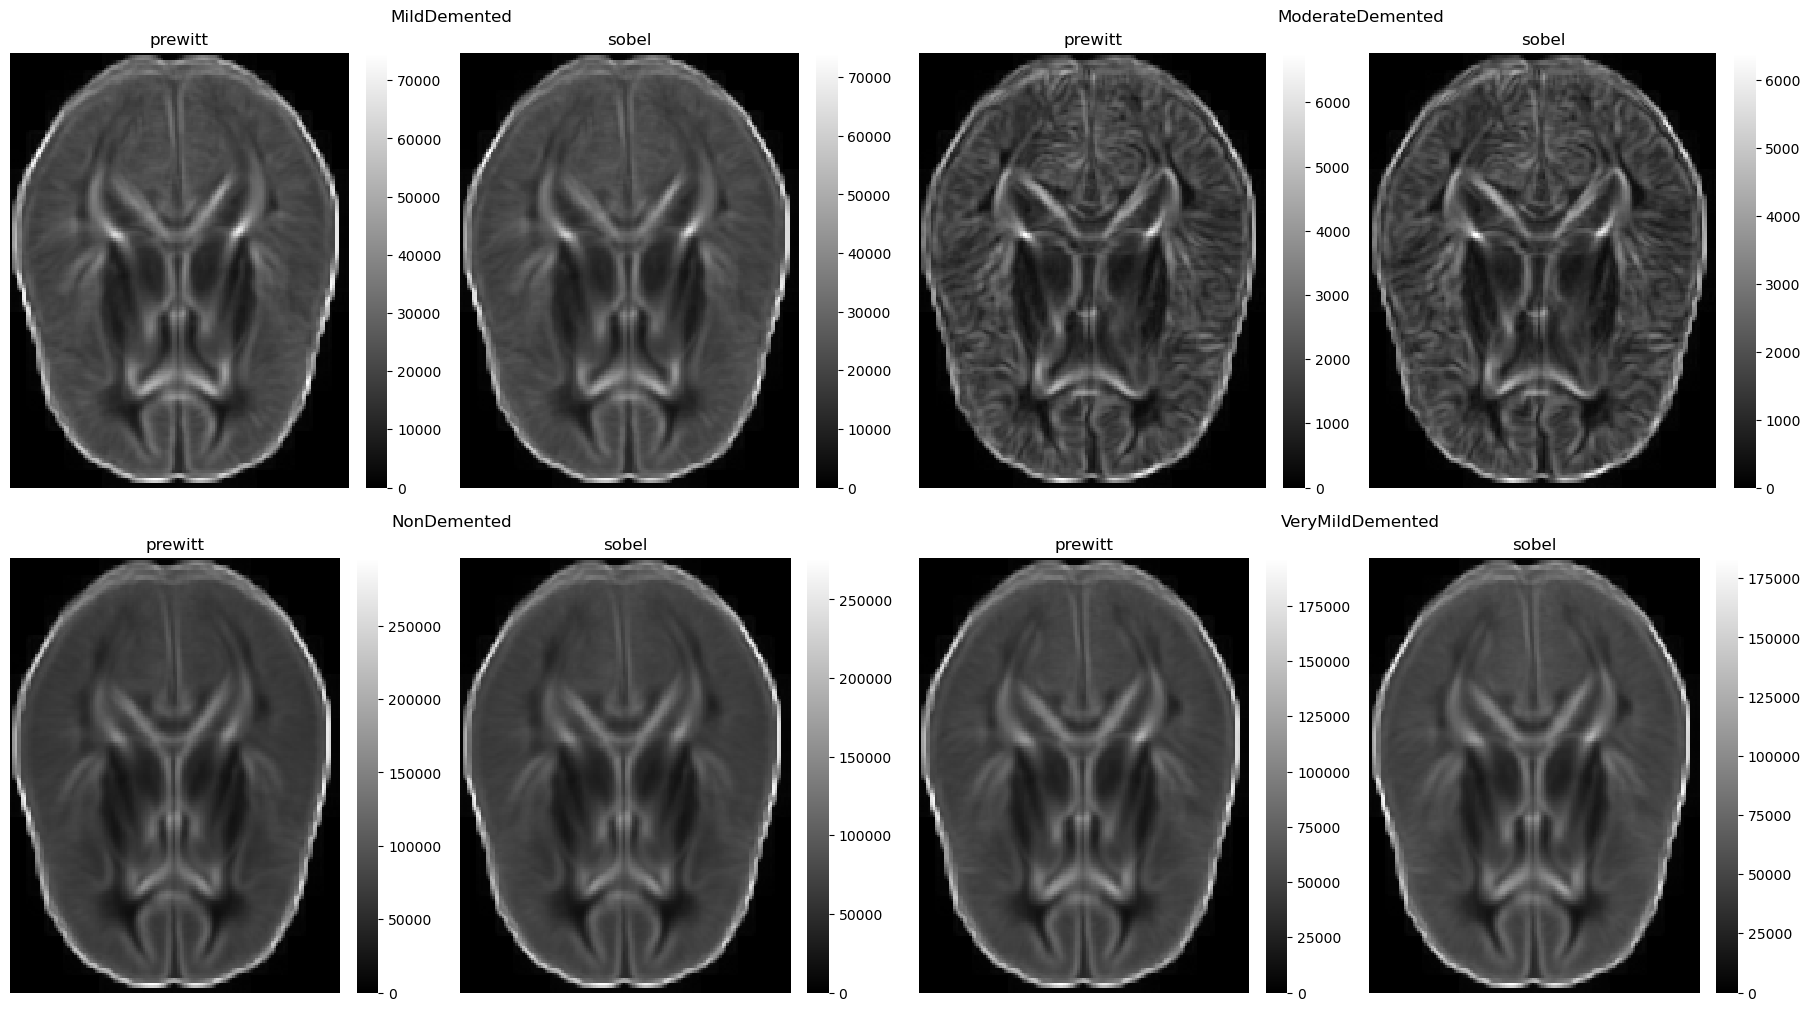

In [54]:
plot_side_by_side(prewitt_magnitude, sobel_magnitude, 'prewitt', 'sobel')

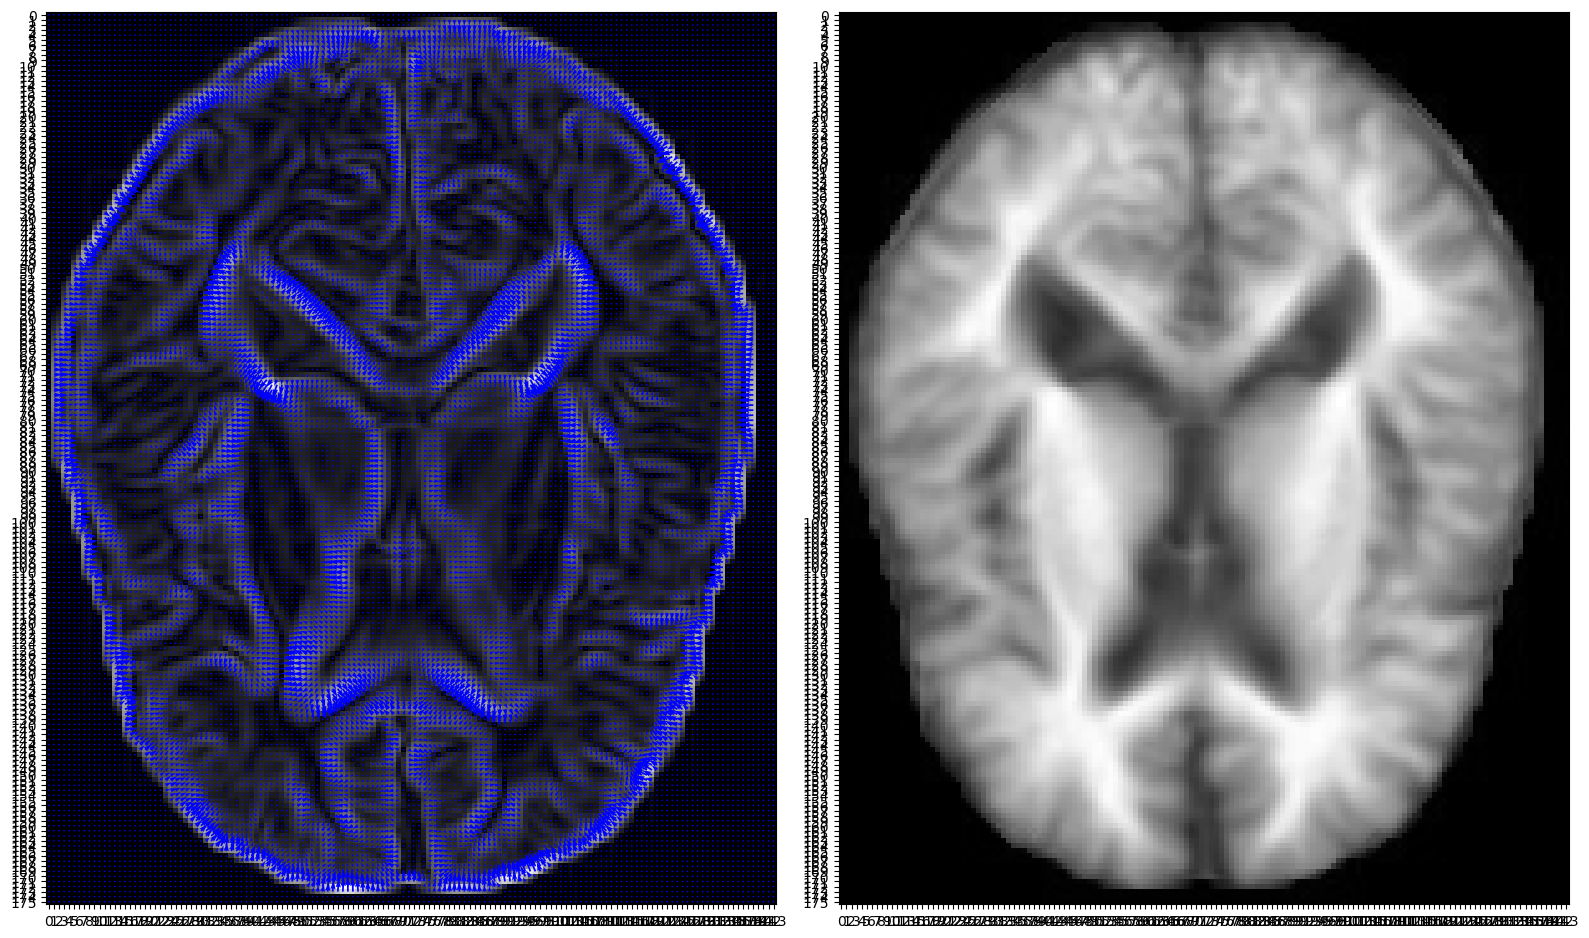

In [55]:
# x_start, x_end = 60, 80
# y_start, y_end = 70, 85
x_start, x_end = 0, images.shape[2]
y_start, y_end = 0, images.shape[1]

# test_image = images[0, y_start:y_end, x_start:x_end]
group_idx = 1
images_group = images[images_labels == group_idx]
test_image = np.sum(images_group, axis=0) / len(images_group)
# print(test_image, images[0, 84, 79])
prewitt_test_y_gradient = sp.ndimage.prewitt(test_image, axis=0)
prewitt_test_x_gradient = sp.ndimage.prewitt(test_image, axis=1)
prewitt_test_magnitude = np.sqrt(prewitt_test_x_gradient ** 2 + prewitt_test_y_gradient ** 2)
prewitt_test_magnitude = 255 * prewitt_test_magnitude / prewitt_test_magnitude.max()
prewitt_test_gradient_angle = np.arctan2(prewitt_test_y_gradient, prewitt_test_x_gradient)

y, x = np.mgrid[:y_end-y_start, :x_end-x_start]

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

plt.setp(axes, xticks=np.arange(x_end - x_start), xticklabels=np.arange(x_start, x_end),
         yticks=np.arange(y_end - y_start), yticklabels=np.arange(y_start, y_end))
# plt.xticks(rotation=45)
# plt.yticks(rotation=45)

axes[0].imshow(prewitt_test_magnitude, cmap='gray', zorder=1)
# quiver plot is shown upside down so multiplying y coordinates and gradients by -1 for flipping the image and the arrows direction, respectively
axes[0].quiver(x, y, prewitt_test_x_gradient, prewitt_test_y_gradient,
            color='blue', angles='xy', scale_units='xy', units='width', scale=90, zorder=2)
# axes[0].streamplot(x, y, sobel_test_x_gradient, sobel_test_y_gradient,
#                    density=(test_image.shape[0]/30, test_image.shape[1]/30),
#                    arrowsize=1, integration_direction='forward', zorder=2)
axes[1].imshow(test_image, cmap='gray')
fig.tight_layout()

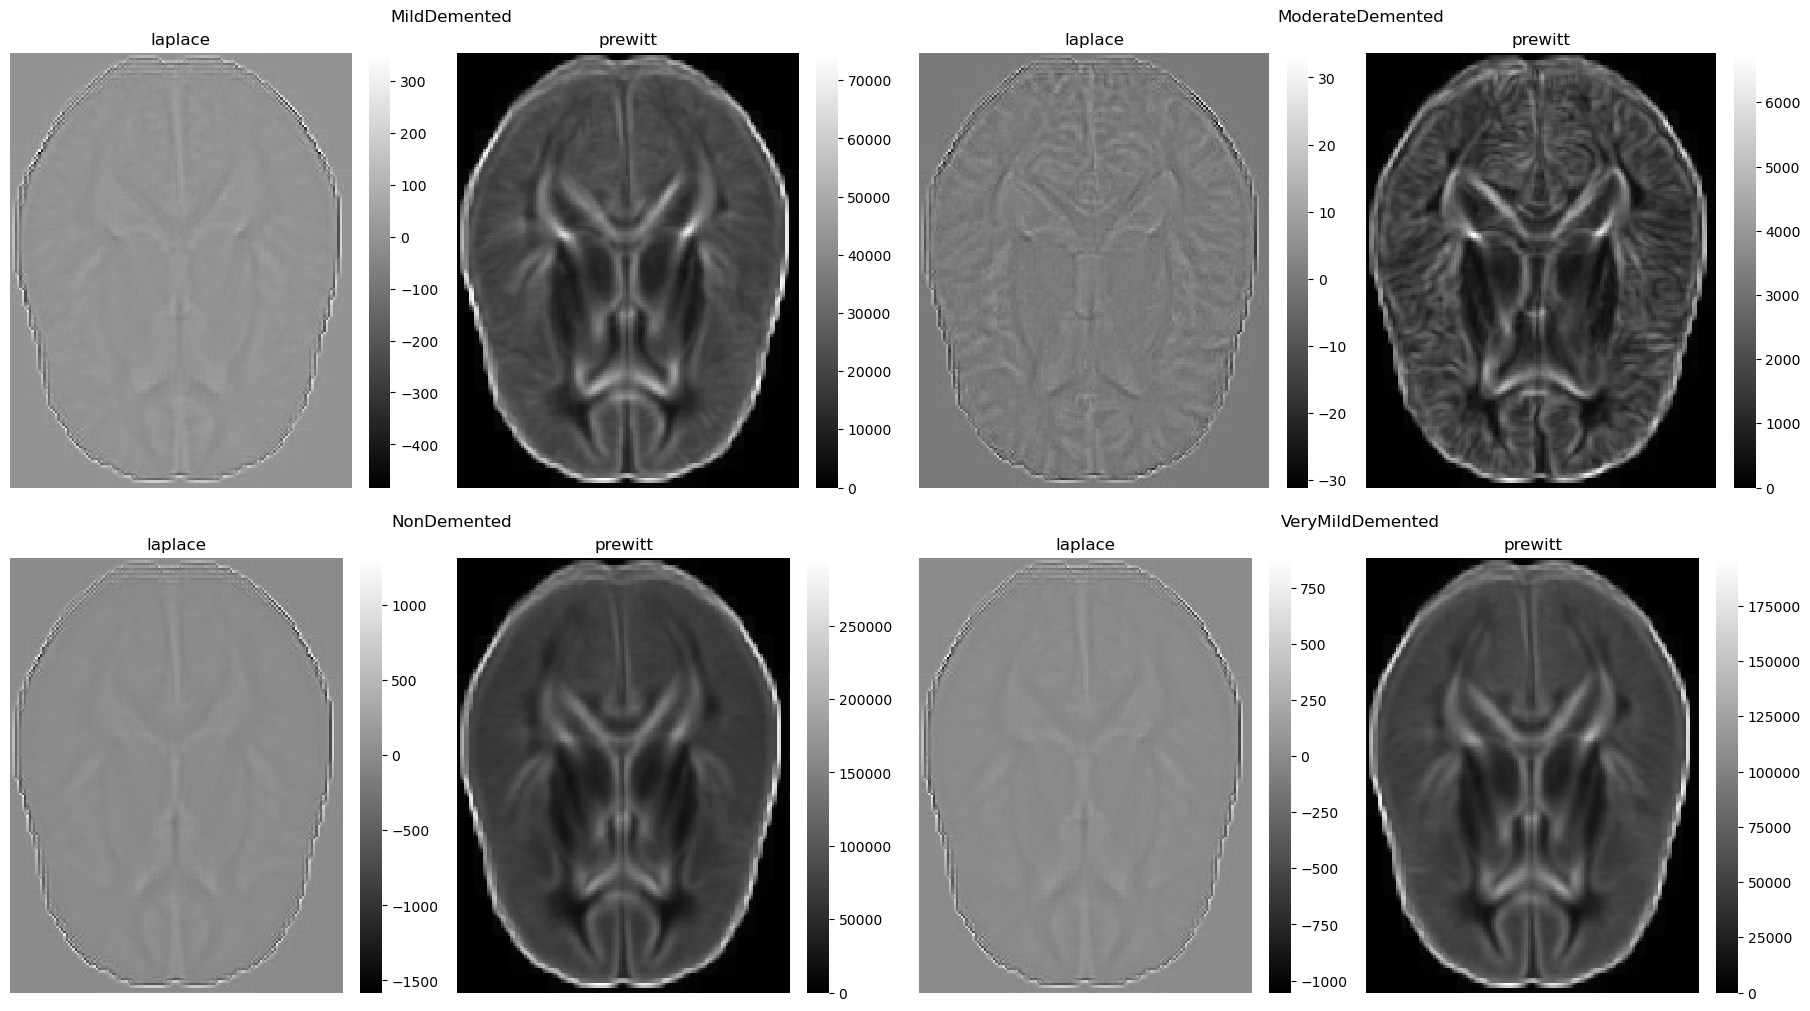

In [56]:
plot_side_by_side(sp.ndimage.laplace(images / 255, cval=0), prewitt_magnitude, 'laplace', 'prewitt')

### Data Augmentation

#### Rotating the images

In [57]:
rotated_25 = sp.ndimage.rotate(images, 25, axes=(1, 2), reshape=False)

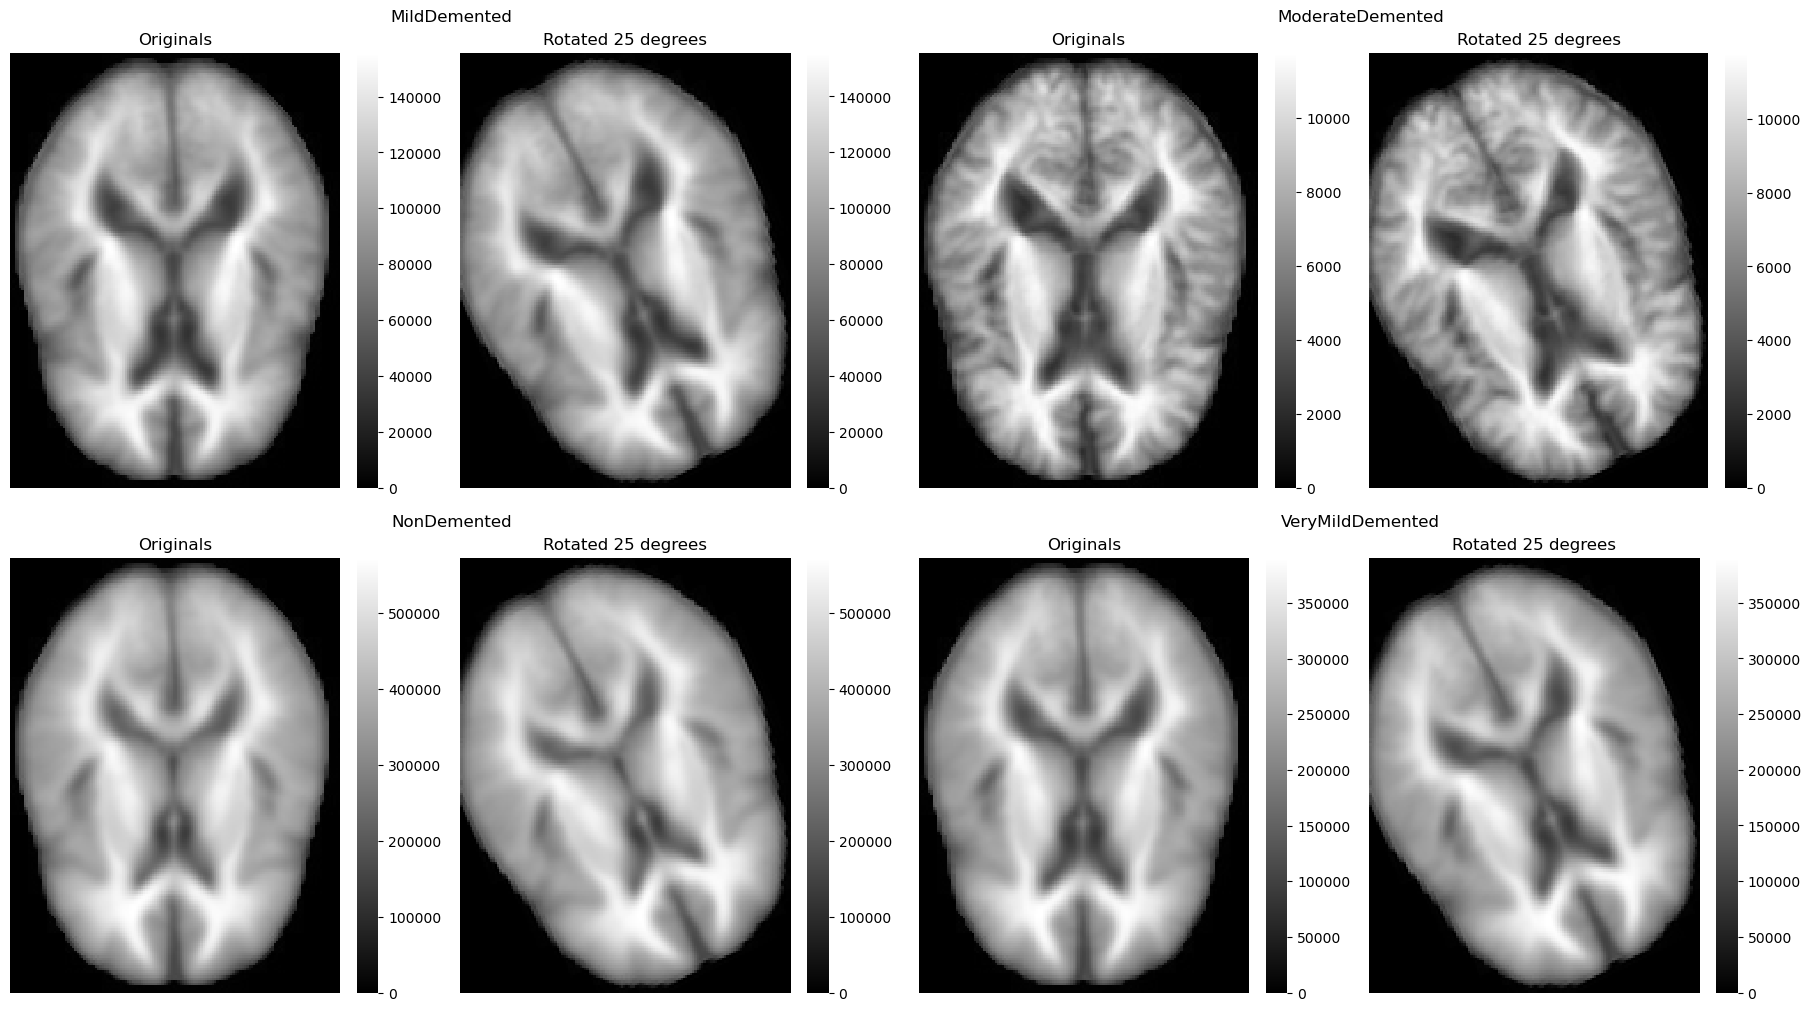

In [58]:
plot_side_by_side(images, rotated_25, 'Originals', 'Rotated 25 degrees')

In [59]:
# images = np.concatenate((images, rotated_25), axis=0)
# images_labels = np.concatenate((images_labels, images_labels), axis=0)
del rotated_25

In [60]:
# plot_side_by_side(images, images[..., :, ::-1], 'Original', 'Flipped')

In [61]:
# flipping the horizontal axis as we're assuming (getting also the -25 rotated images)
flipped_images = images[..., ::-1]

In [62]:
images = np.concatenate((images, flipped_images), axis=0)
images_labels = np.concatenate((images_labels, images_labels), axis=0)

In [63]:
images.shape, images_labels.shape

((10242, 176, 144), (10242,))

#### Training a variational autoencoder for augmenting randomized corrupted data to create new samples

In [64]:
import torch
from torch import nn

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Preparing data for PyTorch

In [66]:
class AlzheimerDataset(torch.utils.data.Dataset):
    def __init__(self, np_images, np_labels, transform=None, target_transform=None):
        self.X = torch.from_numpy(np_images).to(torch.float32).unsqueeze(dim=1) # adding the single channel
        self.y = torch.from_numpy(np_labels)
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        images = self.X[idx]
        labels = self.y[idx]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        
        return images, labels

#### Defining encoder and decoder

In [67]:
# from torch.nn import functional as F

In [68]:
import modules.models
from modules.models.models import ConvAutoEncoder, kl_divergence_loss

In [69]:
perm = torch.randperm(images.shape[0])
val_indices = perm[:int(images.shape[0] * 0.15)].numpy()

In [70]:
from modules.models.dataset import AlzheimerDataset

alzheimer_dataset = AlzheimerDataset(images, images_labels)

# train_dataset = AlzheimerDataset(images[~val_indices], images_labels[~val_indices])
# val_dataset = AlzheimerDataset(images[val_indices], images_labels[val_indices])

#### Using Optuna for hyperparameters optimization
##### Initially, the tuning was manual, and I was getting ~8000 Overall loss values (MSE + lambda * KLE Div), and after changing the optimizer from Adam to SGD and tweaking the learning rate and adding dampening, it went down to ~2000. With Optuna it found a set of hyperparameters with a loss value of 600!

In [71]:
import modules.db
from modules.db.optuna_report import report_optuna_trial, report_study_best_loss_value, get_best_hyperparameters, get_last_study_id

In [72]:
# using tensorboard for displaying training progress and metrices in real time
from torch.utils.tensorboard import SummaryWriter
import optuna

In [73]:
if not os.path.isdir('./data/studies'):
    os.mkdir('./data/studies')
studies_directories = os.listdir('./data/studies/')
# if last study wasn't finished, use that study id in tensorboard and later on in resuming the optuna study
if len(studies_directories) > 0:
    current_study_id = studies_directories[-1].split('-')[-1]
# last study finished successfully so we'll start a brand new one
else:
    current_study_id = get_last_study_id() + 1
current_study_id

46

In [74]:
def train_epoch(model, optimizer, loss, regularization_lambda, dataloader, val_dataset, overall_losses,
                kl_divergence_losses, main_losses,val_overall_losses, val_kl_divergence_losses, val_main_losses,
                epoch, scheduler=None, writer=None):
    for _, (batch_X, _) in enumerate(dataloader):
        batch_X = batch_X.to(device)
        
        optimizer.zero_grad()
        
        _, batch_encoded_mean, batch_encoded_log_var, batch_decoded_output = model(batch_X)
        # batch_decoded_output = autoencoder(batch_X)
    
        batch_main_loss = loss(batch_decoded_output, batch_X)
        # batch_loss = batch_mse_loss
        batch_kl_divergence_loss = kl_divergence_loss(batch_encoded_mean, batch_encoded_log_var)
        batch_loss = batch_main_loss + regularization_lambda * batch_kl_divergence_loss
    
        batch_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            overall_losses[epoch] += batch_loss.item() * batch_X.shape[0]
            kl_divergence_losses[epoch] += batch_kl_divergence_loss.item() * batch_X.shape[0]
            main_losses[epoch] += batch_main_loss.item() * batch_X.shape[0]
    
    # updating train metrics
    overall_losses[epoch] /= dataloader.dataset.X.shape[0]
    kl_divergence_losses[epoch] /= dataloader.dataset.X.shape[0]
    main_losses[epoch] /= dataloader.dataset.X.shape[0]

    if writer:
        writer.add_scalar('Overall Loss/Train', overall_losses[epoch], epoch)
        writer.add_scalar('KL Div Loss/Train', kl_divergence_losses[epoch], epoch)
        writer.add_scalar('MSE Loss/Train', main_losses[epoch], epoch)
        
    # validation
    with torch.no_grad():
        model.eval()
        encoded_output, encoded_mean, encoded_log_var, decoded_output = model(val_dataset.X.to(device))
        # decoded_output = model(dataset.X.to(device))
        loss_value = loss(decoded_output, val_dataset.X.to(device))
        # output_loss = loss_value
        kl_divergence_loss_value = kl_divergence_loss(encoded_mean, encoded_log_var)
        output_loss = loss_value + regularization_lambda * kl_divergence_loss_value

        val_overall_losses[epoch] = output_loss.item()
        val_kl_divergence_losses[epoch] = kl_divergence_loss_value.item()
        val_main_losses[epoch] = loss_value.item()

        if writer:
            writer.add_scalar('Overall Loss/Validation', val_overall_losses[epoch], epoch)
            writer.add_scalar('KL Div Loss/Validation', val_kl_divergence_losses[epoch], epoch)
            writer.add_scalar('MSE Loss/Validation', val_main_losses[epoch], epoch)
            # setting image pixel values to [0, 255] range
            image = decoded_output[5121].squeeze().cpu()
            image += torch.abs(image.min()) # incrementing (possibly negative) lowest values to be non-negative
            # normalizing and setting in range [0, 255]
            image /= image.max()
            image *= 255
            # rounding for best accuracy in pixel values (ceil and floor)
            image = torch.round(image).to(torch.uint8)
            # sending the required format to tensorboard (not very optimistic on actual results)
            writer.add_image('Image/Validation', image, epoch, dataformats='HW')

    # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None:
        scheduler.step()
    
        
    

In [75]:
# if trial is None we're going for multi-objective optimization or we're normally training
def train(trial, model, optimizer, loss, epochs, regularization_lambda, dataloader, val_dataset, scheduler=None, plot=True, show_progress=True, study_id=None):
    log_dir = f'./logs/study-{study_id}/trial-{trial.number}' if study_id else f'./logs/regular/'
    writer = SummaryWriter(log_dir=log_dir)

    # show the model graph
    writer.add_graph(model, next(iter(dataloader))[0].to(device=model.device))
    
    overall_losses, val_overall_losses = torch.zeros(epochs), torch.zeros(epochs)
    kl_divergence_losses, val_kl_divergence_losses = torch.zeros(epochs), torch.zeros(epochs)
    main_losses, val_main_losses = torch.zeros(epochs), torch.zeros(epochs)
    
    # using tqdm has conflicts with optuna's study progress bar
    epochs_range = tqdm(range(epochs)) if show_progress else range(epochs)
    for epoch in epochs_range:
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            regularization_lambda=regularization_lambda,
            dataloader=dataloader,
            val_dataset=val_dataset,
            val_overall_losses=val_overall_losses,
            val_kl_divergence_losses=val_kl_divergence_losses,
            val_main_losses=val_main_losses,
            overall_losses=overall_losses,
            kl_divergence_losses=kl_divergence_losses,
            main_losses=main_losses,
            scheduler=scheduler,
            writer=writer
        )

        writer.flush()
        
        if trial is not None:
            trial.report(overall_losses[epoch].item(), epoch)

            if trial.should_prune():
                writer.close()
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 6))

        axes[0].plot(overall_losses.cpu(), color='blue', label='Train')
        axes[0].plot(val_overall_losses.cpu(), color='orange', label='Validation')
        axes[0].set_title('Overall Loss')
        
        axes[1].plot(kl_divergence_losses.cpu(), color='blue', label='Train')
        axes[1].plot(val_kl_divergence_losses.cpu(), color='orange', label='Validation')
        axes[1].set_title('KL Divergence Loss')
        
        axes[2].plot(main_losses.cpu(), color='blue', label='Train')
        axes[2].plot(val_main_losses.cpu(), color='orange', label='Validation')
        axes[2].set_title('Main Loss')
        
        fig.legend()
    
    # writer.flush()
    writer.close()
    
    return (overall_losses, val_overall_losses), (kl_divergence_losses, val_kl_divergence_losses), (main_losses, val_main_losses)

In [76]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [77]:
def get_loss_function(loss_idx):
    return nn.MSELoss() if loss_idx == 0 else RMSELoss()

In [78]:
def initialize_hyperparameters(trial):
    encoded_dim = trial.suggest_int('encoded_dim', 2, 64*64)
    initial_out_channels = trial.suggest_int('initial_out_channels', 2, 8)
    # autoencoder = AutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels).to(device)

    lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0.1, 0.4, log=True)
    # beta1 can be used instead of momentum (that's another name for it in the Adam optimizer) but for simplicity we'll generate them both
    beta1 = trial.suggest_float('beta1', 0.8, 0.999)
    beta2 = trial.suggest_float('beta2', 0.5, 0.999)

    momentum = trial.suggest_float('momentum', 0, 0.5)
    dampening = trial.suggest_float('dampening', 0, 0.5)

    optimizer_idx = trial.suggest_int('optimizer_idx', 0, 1)

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.999)

    kl_divergence_lambda = trial.suggest_float('kl_divergence_lambda', 0.5, 5)

    epochs = trial.suggest_int('epochs', 50, 150)
    batch_size = trial.suggest_int('batch_size', 32, 256)

    loss_idx = trial.suggest_int('loss_idx', 0, 0)

    relu_slope = trial.suggest_float('relu_slope', 0, 0.1)

    return encoded_dim, initial_out_channels, lr, weight_decay, (beta1, beta2), momentum, dampening, optimizer_idx, \
          scheduler_gamma, kl_divergence_lambda, epochs, batch_size, loss_idx, relu_slope

In [79]:
def multi_objective(trial):
    (encoded_dim,
     initial_out_channels,
     lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     kl_divergence_lambda,
     epochs,
     batch_size,
     loss_idx,
     relu_slope) = initialize_hyperparameters(trial)
    
    autoencoder = ConvAutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels,
                                   pooling_type='max', relu_slope=relu_slope, device=device).to(device)
    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    # optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_loss_function(loss_idx)

    # dataset_idx = trial.suggest_int('dataset_idx', 0, 2)
    # dataset = datasets[dataset_idx]

    dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

    overall, kl_divergence, main_loss = train(
        model=autoencoder,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        regularization_lambda=kl_divergence_lambda,
        dataloader=dataloader,
        val_dataset=alzheimer_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=None,
        study_id=current_study_id
    )

    overall_train_losses, val_overall_losses = overall
    kl_divergence_train_losses, val_kl_divergence_train_losses = kl_divergence
    main_train_losses, val_main_losses = main_loss

    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)

    return kl_divergence_train_losses[-1].item(), main_train_losses[-1].item()  
    

In [80]:
def objective(trial):
    (encoded_dim,
     initial_out_channels,
     lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     kl_divergence_lambda,
     epochs,
     batch_size,
     loss_idx,
     relu_slope) = initialize_hyperparameters(trial)

    autoencoder = ConvAutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels,
                                   pooling_type='max', relu_slope=relu_slope, device=device).to(device)
    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    # optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_loss_function(loss_idx)
    
    dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _, _ = train(
        model=autoencoder,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        regularization_lambda=kl_divergence_lambda,
        dataloader=dataloader,
        val_dataset=alzheimer_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=trial,
        study_id=current_study_id
    )
    
    overall_train_losses, val_overall_losses = overall
    
    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)
    
    return_value = overall_train_losses[-1].item()
    # # if loss is RMSE, return squared value to compare same range of values with MSE
    return np.power(return_value, 2) if loss_idx == 1 else return_value

In [81]:
import nest_asyncio
# mandatory for getting the event loop in a jupyter notebook to be able to run asynchronous functions
# nest_asyncio.apply()

In [82]:
def callback(study, trial):
    report_optuna_trial(study, trial)

In [83]:
def optimize(is_multi_objective, study_name, n_trials=100):
    directions = ['minimize', 'minimize'] if is_multi_objective else ['minimize']
    objective_func = multi_objective if is_multi_objective else objective
    
    # creating a directory for the study to be able to store and continue where we left off
    if not os.path.isdir(f'./data/{study_name}'):
        os.mkdir(f'./data/studies/{study_name}')
    # using sqlite instead of postgresql like the db we're reporting to since our infrastructure already supports reporting to the postgresql db during
    # the trials and reporting straight from here will mess the db
    storage_name = f'sqlite:////./data/studies/{study_name}/{study_name}.db'

    n_trials = np.clip(n_trials, 50, 200)

    study = optuna.create_study(study_name=study_name, storage=storage_name, directions=directions, load_if_exists=True)
    study.optimize(objective_func, n_trials=n_trials, timeout=20000*(n_trials // 30), show_progress_bar=True, gc_after_trial=True, callbacks=[callback])

    return study

In [84]:
is_multi_objective = False
study_name = f'study-{current_study_id}'
n_trials = 301
# study = optimize(is_multi_objective=is_multi_objective, study_name=study_name, n_trials=n_trials)

In [85]:
# checking if the study variable was defined, meaning we executed a study, and we want plot data from optimization process
studied = 'study' in vars()

In [86]:
# update the best loss value on study table with the correct dataset size to get best normalized loss value overall
if studied:
    study_id = report_study_best_loss_value(dataset_size=alzheimer_dataset.X.shape[0])
    # removing the study directory when study is complete
    os.rmdir(f'./data/studies/{study_name}')

In [87]:
import optuna.visualization as vis

In [88]:
if studied:
    vis.plot_param_importances(study).show(renderer='browser')

In [89]:
if studied:
    if is_multi_objective:
        fig = vis.plot_optimization_history(study, target=lambda t: t.values[0], target_name='KL Divergence')
    else:
        fig = vis.plot_optimization_history(study)
    fig.show(renderer='browser')

In [90]:
if studied:
    if is_multi_objective:
        fig = vis.plot_optimization_history(study, target=lambda t: t.values[1], target_name='MSE')
    fig.show(renderer='browser')

In [91]:
if studied:
    if is_multi_objective:
        fig = vis.plot_slice(study, target=lambda t: t.values[0], target_name='KL Divergence')
    else:
        fig = vis.plot_slice(study)
    fig.show(renderer='browser')

In [92]:
if studied:
    if is_multi_objective:
        fig = vis.plot_slice(study, target=lambda t: t.values[1], target_name='MSE')
    else:
        fig = vis.plot_slice(study)
    fig.show(renderer='browser')

In [93]:
if is_multi_objective or not studied:
    (encoded_dim, 
     initial_out_channels,
     learning_rate,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     kl_divergence_lambda,
     epochs,
     batch_size,
     relu_slope) = get_best_hyperparameters(from_last_study=studied) # get hyperparameters from the study, if studied
    best_params = {
        'encoded_dim': encoded_dim,
        'initial_out_channels': initial_out_channels,
        'lr': learning_rate,
        'weight_decay': weight_decay,
        'betas': betas,
        'momentum': momentum,
        'dampening': dampening,
        'optimizer_idx': optimizer_idx,
        'scheduler_gamma': scheduler_gamma,
        'kl_divergence_lambda': kl_divergence_lambda,
        'epochs': epochs,
        'batch_size': batch_size,
        'loss_idx': 0,
        'relu_slope': relu_slope
    }
else:
    best_params = study.best_trial.params

In [94]:
best_params

{'encoded_dim': 414,
 'initial_out_channels': 8,
 'lr': 0.006688453300893346,
 'weight_decay': 0.11503670509750329,
 'betas': (0.8429095787676122, 0.6154875664691886),
 'momentum': 0.24668464332837217,
 'dampening': 0.09684209978086347,
 'optimizer_idx': 1,
 'scheduler_gamma': 0.9396948532084324,
 'kl_divergence_lambda': 1.1462528683850681,
 'epochs': 117,
 'batch_size': 32,
 'loss_idx': 0,
 'relu_slope': 0}

In [95]:
encoded_dim = best_params['encoded_dim']
initial_out_channels = best_params['initial_out_channels']
relu_slope = best_params['relu_slope']
 
autoencoder = ConvAutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels,
                              pooling_type='max', relu_slope=relu_slope, device=device).to(device)
encoder = autoencoder.encoder
decoder = autoencoder.decoder

In [96]:
sum(p.numel() for p in autoencoder.parameters())

2473486

In [97]:
# lr = 0.008
lr = best_params['lr']
weight_decay = best_params['weight_decay']
betas = (best_params.get('beta1'), best_params.get('beta2'))
momentum = best_params['momentum']
dampening = best_params['dampening']
optimizer_idx = best_params.get('optimizer_idx')
scheduler_gamma = best_params['scheduler_gamma']

if optimizer_idx is not None and optimizer_idx == 0:
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
else:
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
# mse = nn.MSELoss()
loss = get_loss_function(best_params['loss_idx'])

# kl_divergence_lambda = 3
kl_divergence_lambda = best_params['kl_divergence_lambda']

In [98]:
epochs = best_params['epochs']
batch_size = best_params['batch_size']
# dataset_idx = best_params['dataset_idx']

dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 12581 / 13248 (95.0%)
Greatest absolute difference: 582733440.0 at index (0, 385) (up to 1e-05 allowed)
Greatest relative difference: 2451.252504997171 at index (3, 393) (up to 1e-05 allowed)
  _check_trace(
c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 4. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 446857 / 811008 (55.1%)
Greatest absolute difference: 566123.8828125 at index (25, 0, 84, 34) (up to 1e-05 allowed)
Greatest relative difference: inf at index (0, 0, 4, 8) (up to 1e-05 allowed)
  _check_trace(


  0%|          | 0/117 [00:00<?, ?it/s]

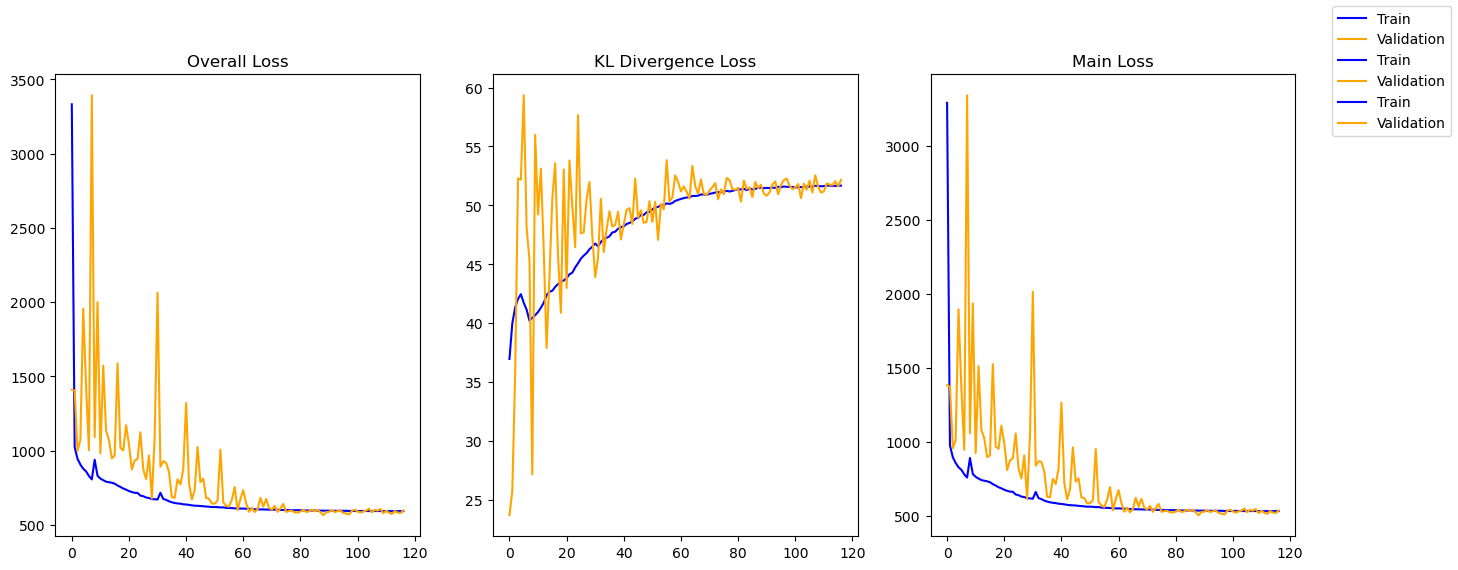

In [99]:
overall, kl_divergence, main = train(
    model=autoencoder,
    optimizer=optimizer,
    loss=loss,
    epochs=epochs,
    regularization_lambda=kl_divergence_lambda,
    dataloader=dataloader,
    val_dataset=alzheimer_dataset,
    scheduler=scheduler,
    plot=True,
    trial=None
)

overall_train_losses, val_overall_losses = overall
kl_divergence_train_losses, val_kl_divergence_train_losses = kl_divergence
main_train_losses, val_main_losses = main

In [100]:
image_to_generate = images[5121]
# getting a generated image from the original
with torch.no_grad():
    # expanding the channel
    original_batched_image = np.expand_dims(image_to_generate, axis=0)
    # expanding batch
    original_batched_image = np.expand_dims(original_batched_image, axis=0)
    _, _, _, generated_image = autoencoder(torch.from_numpy(original_batched_image) \
                                  .to(device=device, dtype=torch.float32))
    
    generated_image = generated_image.flatten(start_dim=0, end_dim=2)
    print(generated_image.shape)

    laplace_filtered_generated_image = sp.ndimage.laplace(generated_image.cpu().numpy(), mode='constant', cval=0)

torch.Size([176, 144])


(169.80496, 84.15182)

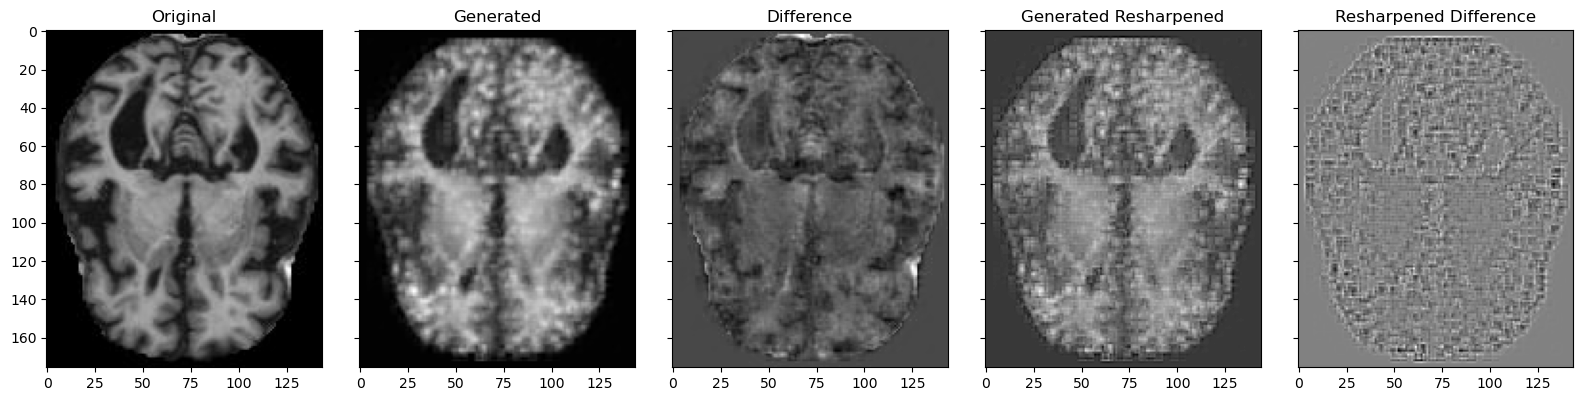

In [101]:
fig, axes = plt.subplots(1, 5, figsize=(16, 10), sharey=True, sharex=True)
fig.tight_layout()

axes[0].set_title('Original')
axes[0].imshow(image_to_generate, cmap='gray')
axes[1].set_title('Generated')
axes[1].imshow(generated_image.cpu(), cmap='gray')
axes[2].set_title('Difference')
axes[2].imshow(image_to_generate - generated_image.cpu().numpy(), cmap='gray')
axes[3].set_title('Generated Resharpened')
axes[3].imshow(generated_image.cpu().numpy() - laplace_filtered_generated_image, cmap='gray')
axes[4].set_title('Resharpened Difference')
axes[4].imshow(image_to_generate - (image_to_generate - laplace_filtered_generated_image), cmap='gray')
(image_to_generate - generated_image.cpu().numpy()).max(), (image_to_generate - (image_to_generate - laplace_filtered_generated_image)).max()

In [102]:
single_channel_images = np.expand_dims(images, axis=1)
# single_channels_images = dataset.X

with torch.no_grad():
    encoded_images, _, _, _ = encoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    encoded_images = encoded_images.cpu()

In [103]:
encoded_images.shape

torch.Size([10242, 414])

In [104]:
with torch.no_grad():
    _, _, _, decoded_images = autoencoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    decoded_images = decoded_images.cpu()
    # laplace_filtered_decoded_images = sp.ndimage.laplace(decoded_images, mode='constant', cval=0)
    # resharpened_decoded_images = decoded_images - laplace_filtered_decoded_images
    # decoded_images = resharpened_decoded_images

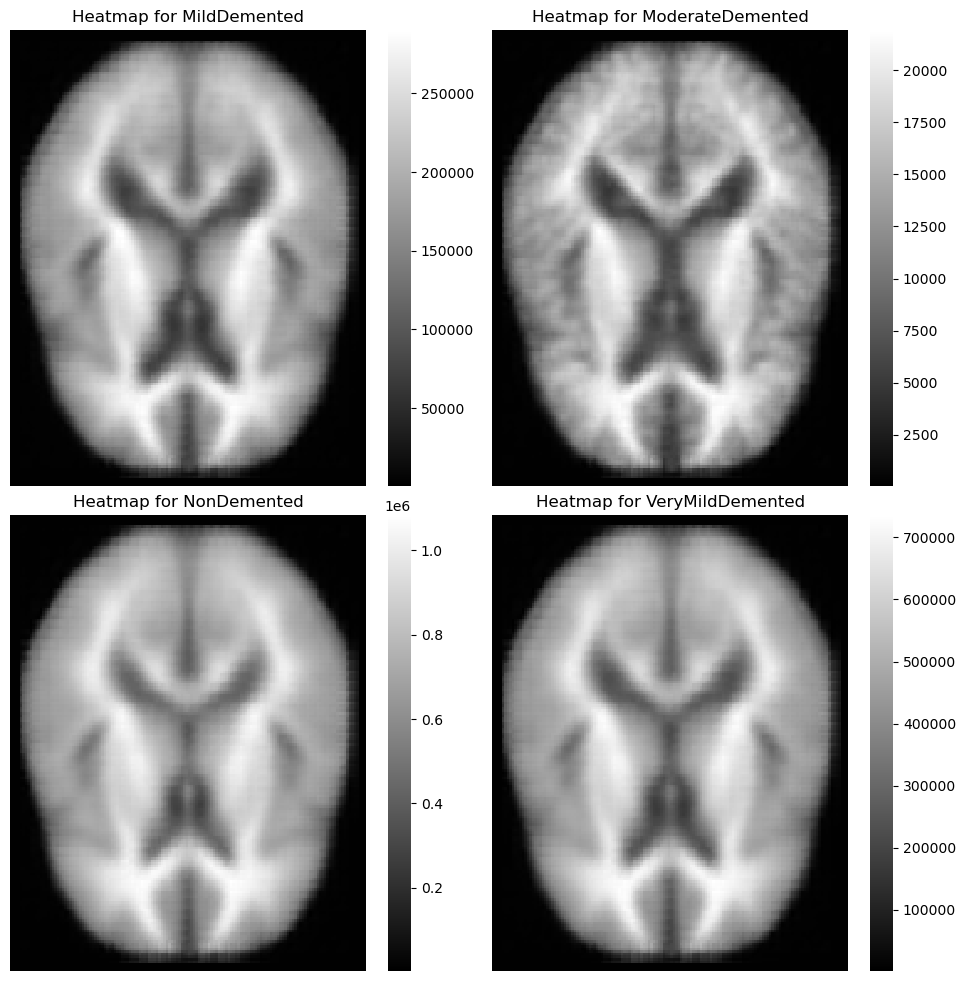

In [105]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

<Axes: ylabel='Count'>

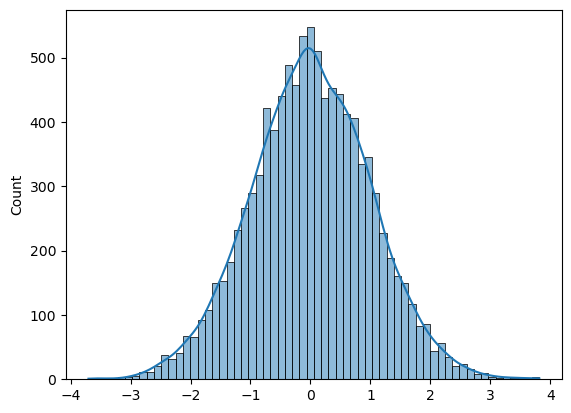

In [106]:
# plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=images_labels)
sns.histplot(encoded_images[:, 0], kde=True)

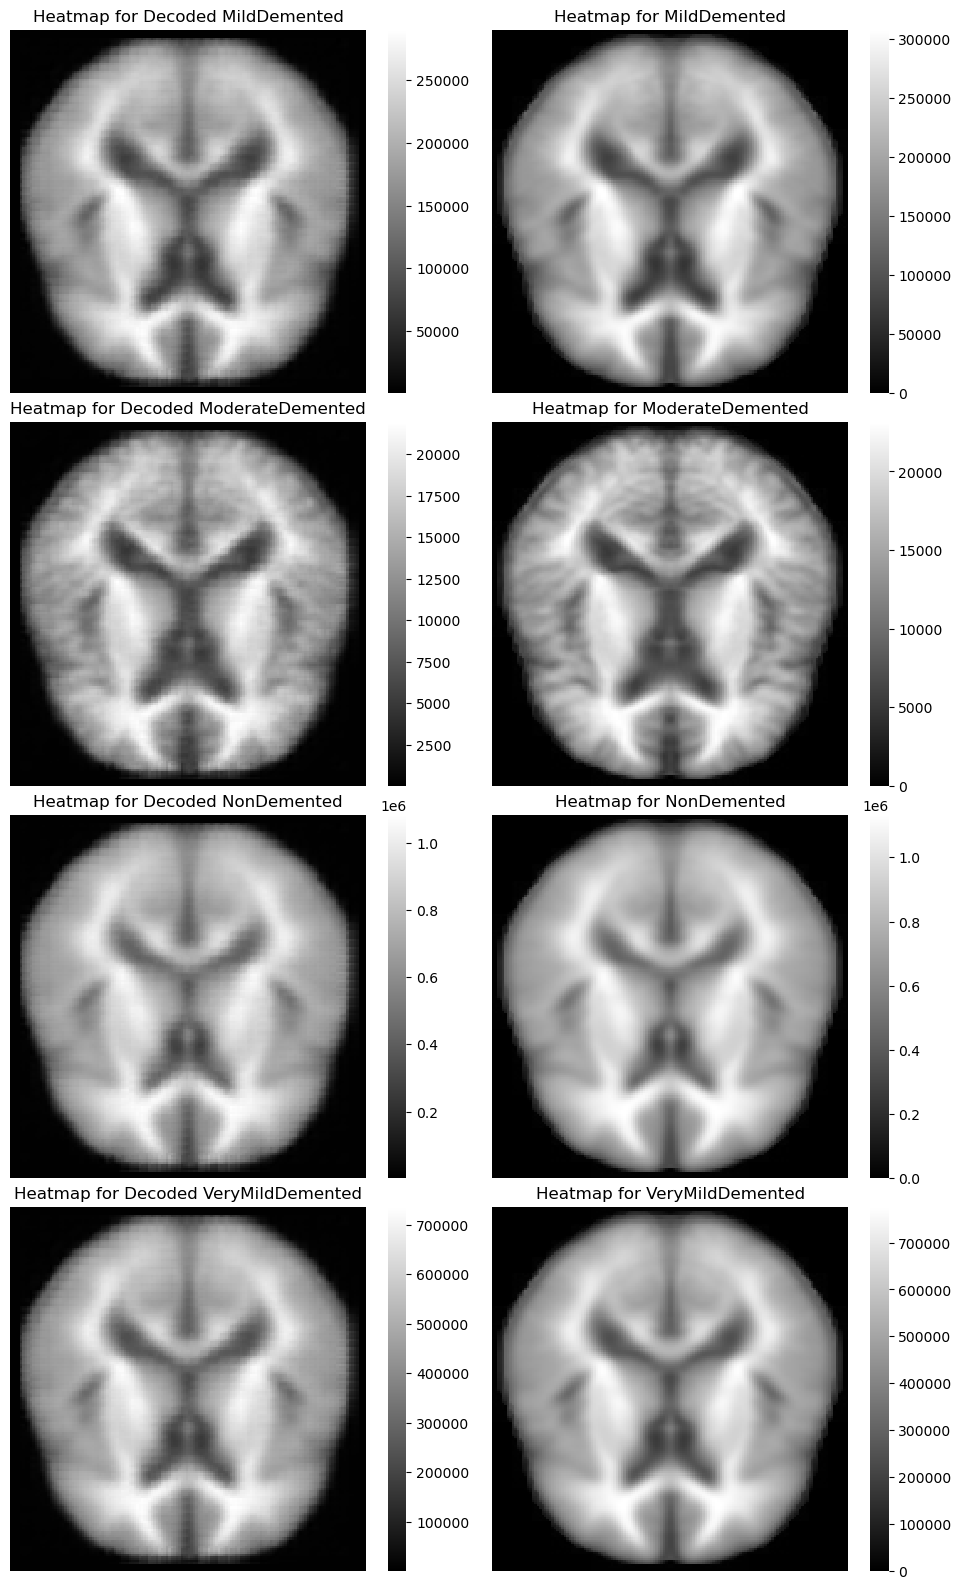

In [107]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax_generated = axes[i, 0]
    ax_original = axes[i, 1]
    generated_class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    original_class_images = images[np.where(images_labels == i)]
    original_heatmap = np.sum(original_class_images, axis=0)
    generated_heatmap = np.sum(generated_class_images, axis=0)
    sns.heatmap(generated_heatmap, ax=ax_generated, cmap='gray')
    sns.heatmap(original_heatmap, ax=ax_original, cmap='gray')
    
    ax_generated.set_title(f'Heatmap for Decoded {classes[i]}')
    ax_generated.get_yaxis().set_visible(False)
    ax_generated.get_xaxis().set_visible(False)
    
    ax_original.set_title(f'Heatmap for {classes[i]}')
    ax_original.get_yaxis().set_visible(False)
    ax_original.get_xaxis().set_visible(False)

In [108]:
from modules.models.utils import save_model

In [109]:
save_model(autoencoder, optimizer, best_params)

length: 265
file ./saved_models/SGD-lr=0.006688453300893346-momentum=0.24668464332837217-dampening=0.09684209978086347-weight_decay=0.11503670509750329-initial_lr=0.006688453300893346-lr=0.006688453300893346kl_lambda=1.1462528683850681-epochs=117-encoded_dim=414-channels=8-bs=32.pt created.


#### Adding noise in the spatial domain to the encoded output and cleaning it in the frequency domain of the decoded images to create new images

In [110]:
# final_images = np.concatenate((np.expand_dims(images, axis=1), decoded_images), axis=0)
final_images = np.expand_dims(images, axis=1)
# final_labels = np.concatenate((images_labels, images_labels), axis=0)
final_labels = images_labels.copy()

In [111]:
def transform_image(image, threshold=None):
    fft_image = np.fft.fft2(image)
    if threshold is None:
        threshold = 0.0005 * np.abs(fft_image)
    # creating a mask for zeroing low amplitudes, i.e: below the threshold
    mask = np.ones_like(fft_image)
    mask[np.abs(fft_image) <= threshold] = 0
    filtered_fft_image = fft_image * mask
    # getting the inverse fourier transform on the filtered image
    inverse_fft_image = np.fft.ifft2(filtered_fft_image)
    transformed_image = np.real(inverse_fft_image * np.conj(inverse_fft_image))
    # normalizing to [0, 255] range
    transformed_image = transformed_image / transformed_image.max()
    
    return transformed_image

In [112]:
desired_min_images = 6000
# number of times we'll add noise and decode the result
num_iterations = desired_min_images // encoded_images.shape[0]

for i in tqdm(range(num_iterations)):
    # indices_to_reset = torch.from_numpy(np.random.choice(np.arange(encoded_dim), int(0.1 * encoded_dim), replace=False))
    # encoded_images[:, indices_to_reset] = 0
    encoded_noise = torch.randn(encoded_images.shape)
    # encoded_noise = np.random.randn(*encoded_images.cpu().numpy().shape)
    noisy_images = encoded_images + encoded_noise
    
    with torch.no_grad():
        noisy_decoded_images = decoder(noisy_images.to(device=device, dtype=torch.float32)).cpu()
        # noisy_decoded_images = transform_image(noisy_decoded_images)
        # laplace_filtered_noisy_decoded_images = sp.ndimage.laplace(noisy_decoded_images, mode='constant', cval=0)
        # noisy_decoded_images = noisy_decoded_images - laplace_filtered_noisy_decoded_images
    
    final_images = np.concatenate((final_images, noisy_decoded_images), axis=0)
    final_labels = np.concatenate((final_labels, images_labels), axis=0)

0it [00:00, ?it/s]

In [113]:
final_images.shape, final_labels.shape

((10242, 1, 176, 144), (10242,))

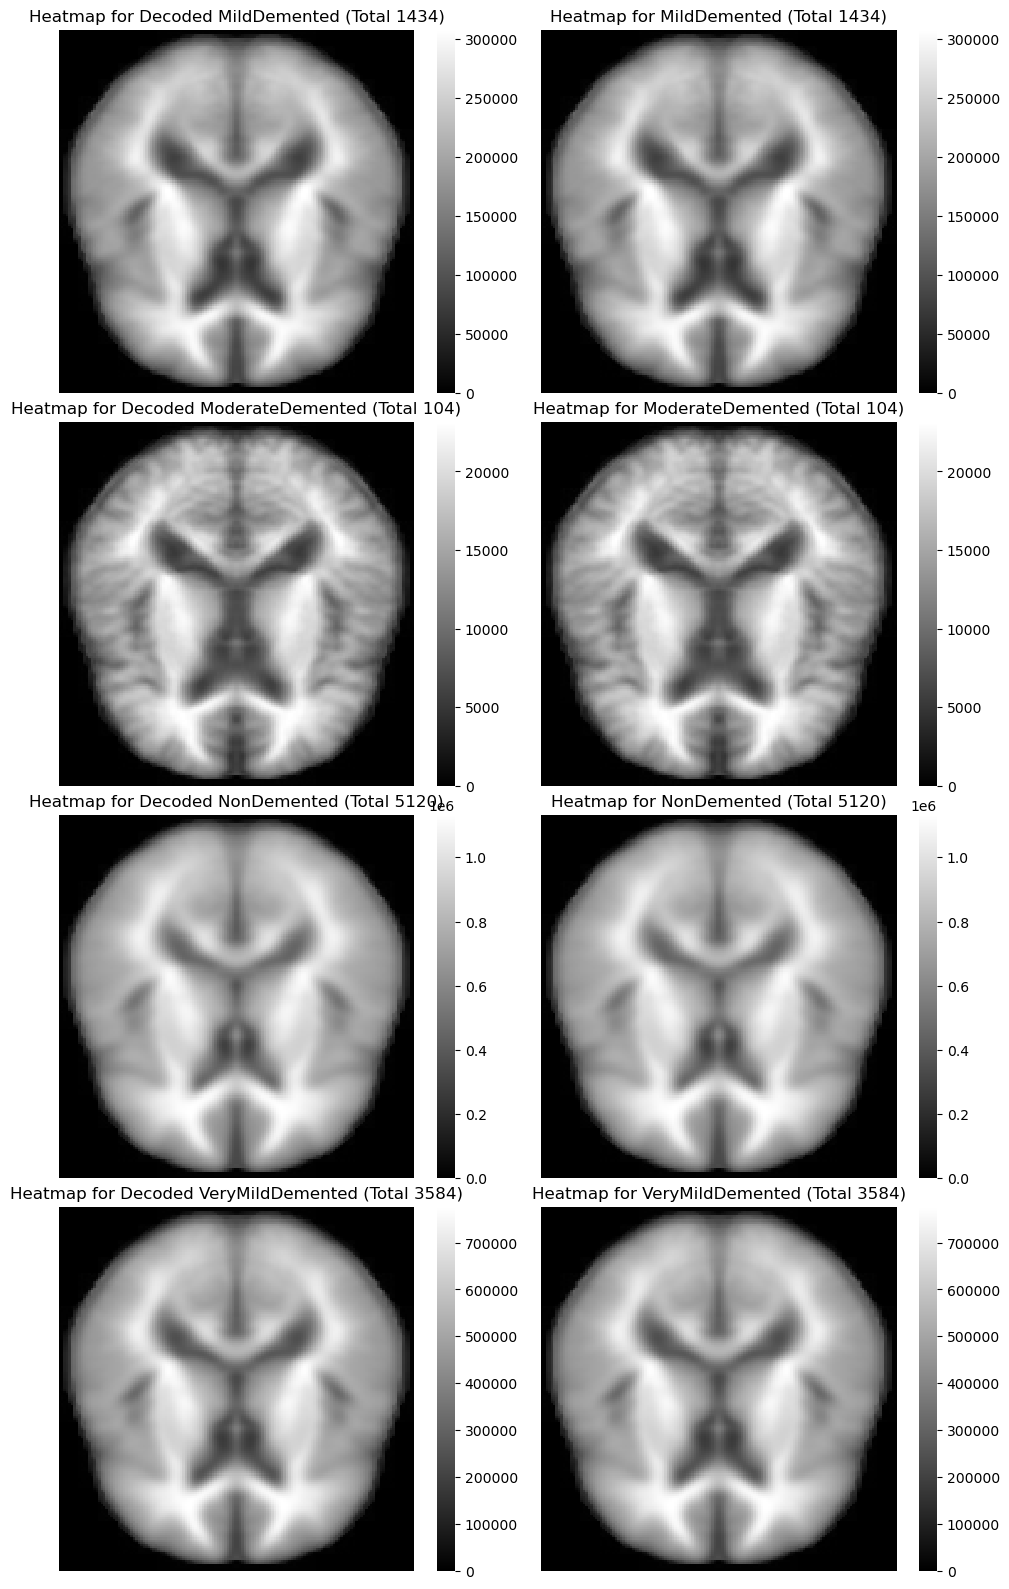

In [114]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax_generated = axes[i, 0]
    ax_original = axes[i, 1]
    generated_class_images = final_images.squeeze()[np.where(final_labels == i)]
    original_class_images = images[np.where(images_labels == i)]
    original_heatmap = np.sum(original_class_images, axis=0)
    generated_heatmap = np.sum(generated_class_images, axis=0)
    sns.heatmap(generated_heatmap, ax=ax_generated, cmap='gray')
    sns.heatmap(original_heatmap, ax=ax_original, cmap='gray')

    ax_generated.set_title(f'Heatmap for Decoded {classes[i]} (Total {generated_class_images.shape[0]})')
    ax_generated.get_yaxis().set_visible(False)
    ax_generated.get_xaxis().set_visible(False)

    ax_original.set_title(f'Heatmap for {classes[i]} (Total {original_class_images.shape[0]})')
    ax_original.get_yaxis().set_visible(False)
    ax_original.get_xaxis().set_visible(False)

#### Saving the decoded and generated images to disk for later use

In [115]:
saved_data_directories = [dir for dir in os.listdir('./data/') if dir.startswith('decoded_data')]
directories_nums = [int(dir.split('_')[-1]) for dir in saved_data_directories if dir.split('_')[-1].isdigit()]
last_directory_num = max(directories_nums)

In [116]:
import h5py

In [117]:
directory_name = f'./data/decoded_data_{last_directory_num + 1}'
if not os.path.exists(directory_name):
    os.mkdir(directory_name)
    with h5py.File(f'{directory_name}/images.h5', 'w') as h5f_images_file:
        h5f_images_file.create_dataset('images', data=final_images, dtype='i')

    with h5py.File(f'{directory_name}/labels.h5', 'w') as h5f_labels_file:
        h5f_labels_file.create_dataset('labels', data=final_labels, dtype='i')

    # # training dataset
    # with h5py.File(f'{directory_name}/train_images.h5', 'w') as h5f_train_images_file:
    #     h5f_train_images_file.create_dataset('images', data=images[~val_indices], dtype='i')

    # with h5py.File(f'{directory_name}/train_labels.h5', 'w') as h5f_train_labels_file:
    #     h5f_train_labels_file.create_dataset('labels', data=images_labels[~val_indices], dtype='i')

    # # validation dataset
    # with h5py.File(f'{directory_name}/val_images.h5', 'w') as h5f_val_images_file:
    #     h5f_val_images_file.create_dataset('images', data=images[val_indices], dtype='i')

    # with h5py.File(f'{directory_name}/val_labels.h5', 'w') as h5f_val_labels_file:
    #     h5f_val_labels_file.create_dataset('labels', data=images_labels[val_indices], dtype='i')

In [118]:
del final_images
del final_labels